In [1]:
import numpy as np
import pandas as pd
import datetime

# visualization
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12,4)
# plt.rcParams['figure.dpi'] = 150

# modeling
from statsmodels.tsa.arima.model import ARIMA

#
from sklearn.metrics import mean_squared_error

#
colors = ['#F0D290','#DE834D','#A3423C','#781D42']
colors2 = ['#f0d290','#e9c083','#e2af77','#d99d6d','#d08c64',
          '#c67b5d','#bc6b56','#b05a51','#a34b4d','#963b49',
          '#872c45','#781d42']

## Data
[dataset source](https://community.tableau.com/s/question/0D54T00000CWeX8SAL/sample-superstore-sales-excelxls)

In [2]:
# loading data & check dataset shape
df = pd.read_excel('../datasets/Sample - Superstore.xls', usecols=['Order Date', 'Product ID', 'Category', 'Sub-Category', 'Sales', 'Quantity', 'Discount', 'Profit'])
df.shape

(9994, 8)

# 1. Data Exploration

In [3]:
### verifying that each column has the appropriate data type
df.dtypes

Order Date      datetime64[ns]
Product ID              object
Category                object
Sub-Category            object
Sales                  float64
Quantity                 int64
Discount               float64
Profit                 float64
dtype: object

#### correlation matrix

In [4]:
# # Generate a mask for the upper triangle
# mask = np.triu(np.ones_like(df.corr(), dtype=bool))

# # plot correlation metric between all possible pairs of numeric variables the dataframe
# sns.heatmap(df.corr(), mask=mask, annot=True, square=True);

#### How much Furniture data represent out of the whole data? 
Answer : 21%

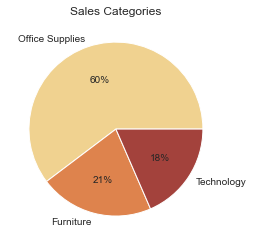

In [5]:
data = df['Category'].value_counts()
plt.title('Sales Categories')
plt.pie(data, 
        labels=data.index,
        colors=colors,
        autopct='%.0f%%');

#### What are the subcategories of Furniture?
Answer : <br>
45% Furnishings <br>
29% Chairs <br>
15% Tables <br>
11% Bookcases <br>

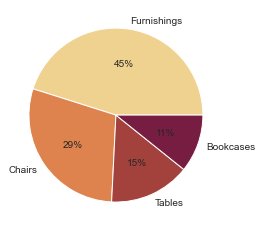

In [6]:
data = df[df['Category'] == 'Furniture']['Sub-Category'].value_counts()
plt.pie(data, 
        labels=data.index,
        colors=colors,
        autopct='%.0f%%');

#### Since we are interested in Furniture category we will drop non-Furniture data

In [7]:
df = df[df['Category'] == 'Furniture'].reset_index()
df.shape

(2121, 9)

#### Is there any missing dates?
Answer : No

In [8]:
# check index for missing days

# first find the number of unique indices
len(df['Order Date'].unique())

889

In [9]:
# then calculate the delta in time plus one (inclusive of first day)
df['Order Date'].max() - df['Order Date'].min()

# 566 Missing dates!

Timedelta('1454 days 00:00:00')

#### Overall data description
- We are mostly interested in the Sales column, we can notice it has values as expected no wrong data.
- We can notice Profit contain negative values.

In [69]:
# describe and EDA
df.describe().round(2)

index   Row ID  Postal Code    Sales  Quantity  Discount   Profit
count  2121.00  2121.00      2121.00  2121.00   2121.00   2121.00  2121.00
mean   5040.64  5041.64     55726.56   349.83      3.79      0.17     8.70
std    2885.74  2885.74     32261.89   503.18      2.25      0.18   136.05
min       0.00     1.00      1040.00     1.89      1.00      0.00 -1862.31
25%    2567.00  2568.00     22801.00    47.04      2.00      0.00   -12.85
50%    5144.00  5145.00     60505.00   182.22      3.00      0.20     7.77
75%    7533.00  7534.00     90032.00   435.17      5.00      0.30    33.73
max    9990.00  9991.00     99301.00  4416.17     14.00      0.70  1013.13

#### Is there any missing values or duplicated rows ?
Answer : No

In [70]:
print(f'Number of missing values is {df.isna().sum().sum()}\nNumber of duplicated rows is {df.duplicated().sum()}')

Number of missing values is 0
Number of duplicated rows is 0


#### Any wrong data in the Sales column ?
Answer : No

In [71]:
print('Number of transactions has Sales <= 0 is ' + str(df[df['Sales'] <= 0].shape[0]))

Number of transactions has Sales <= 0 is 0


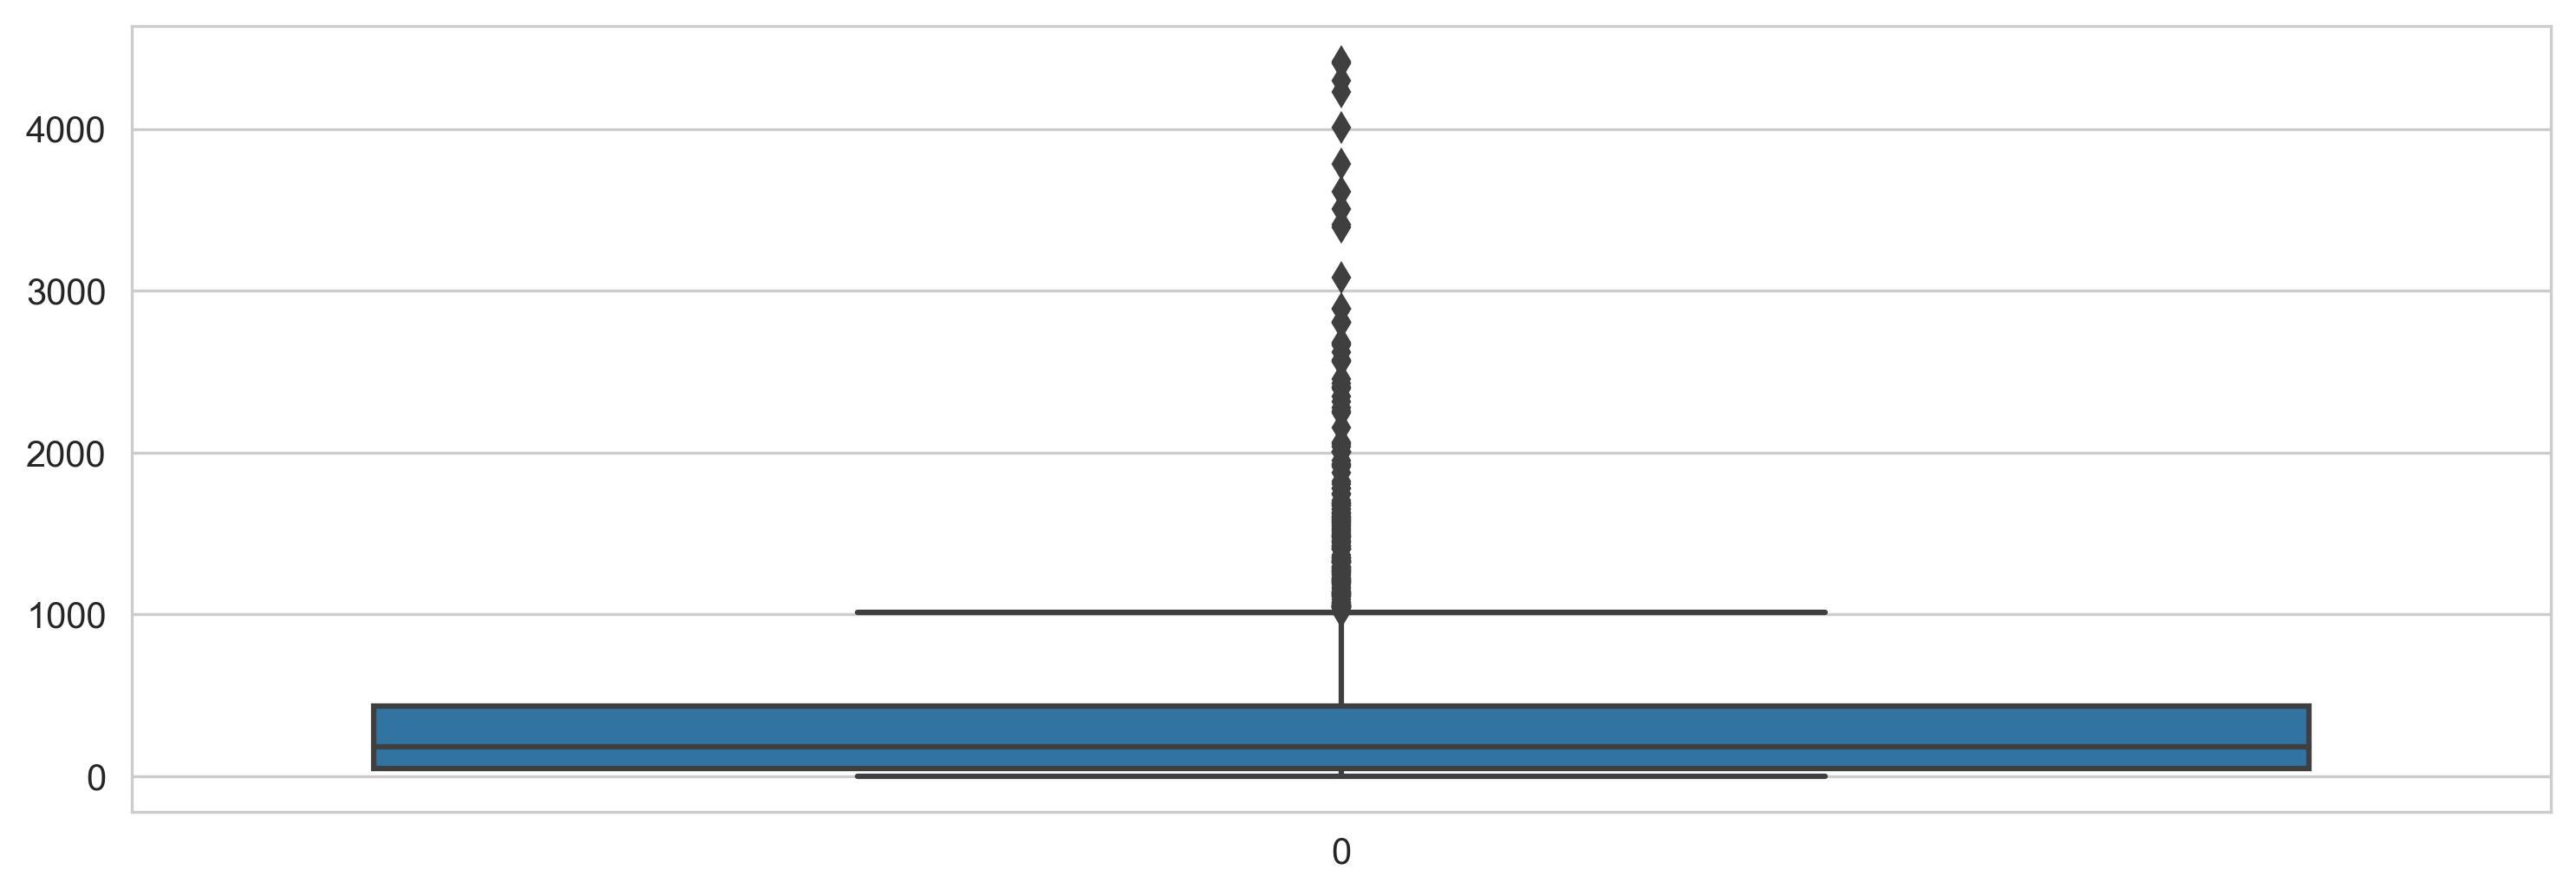

In [72]:
sns.boxplot(data=df['Sales']);

#### Any wrong data in the Profit column ?
Answer : No; Having negative profit seems to be normal scinse the store put big discounts on some products.

In [73]:
print('Number of transactions has Sales <= 0 is ' + str(df[df['Profit'] <= 0].shape[0]))

Number of transactions has Sales <= 0 is 747


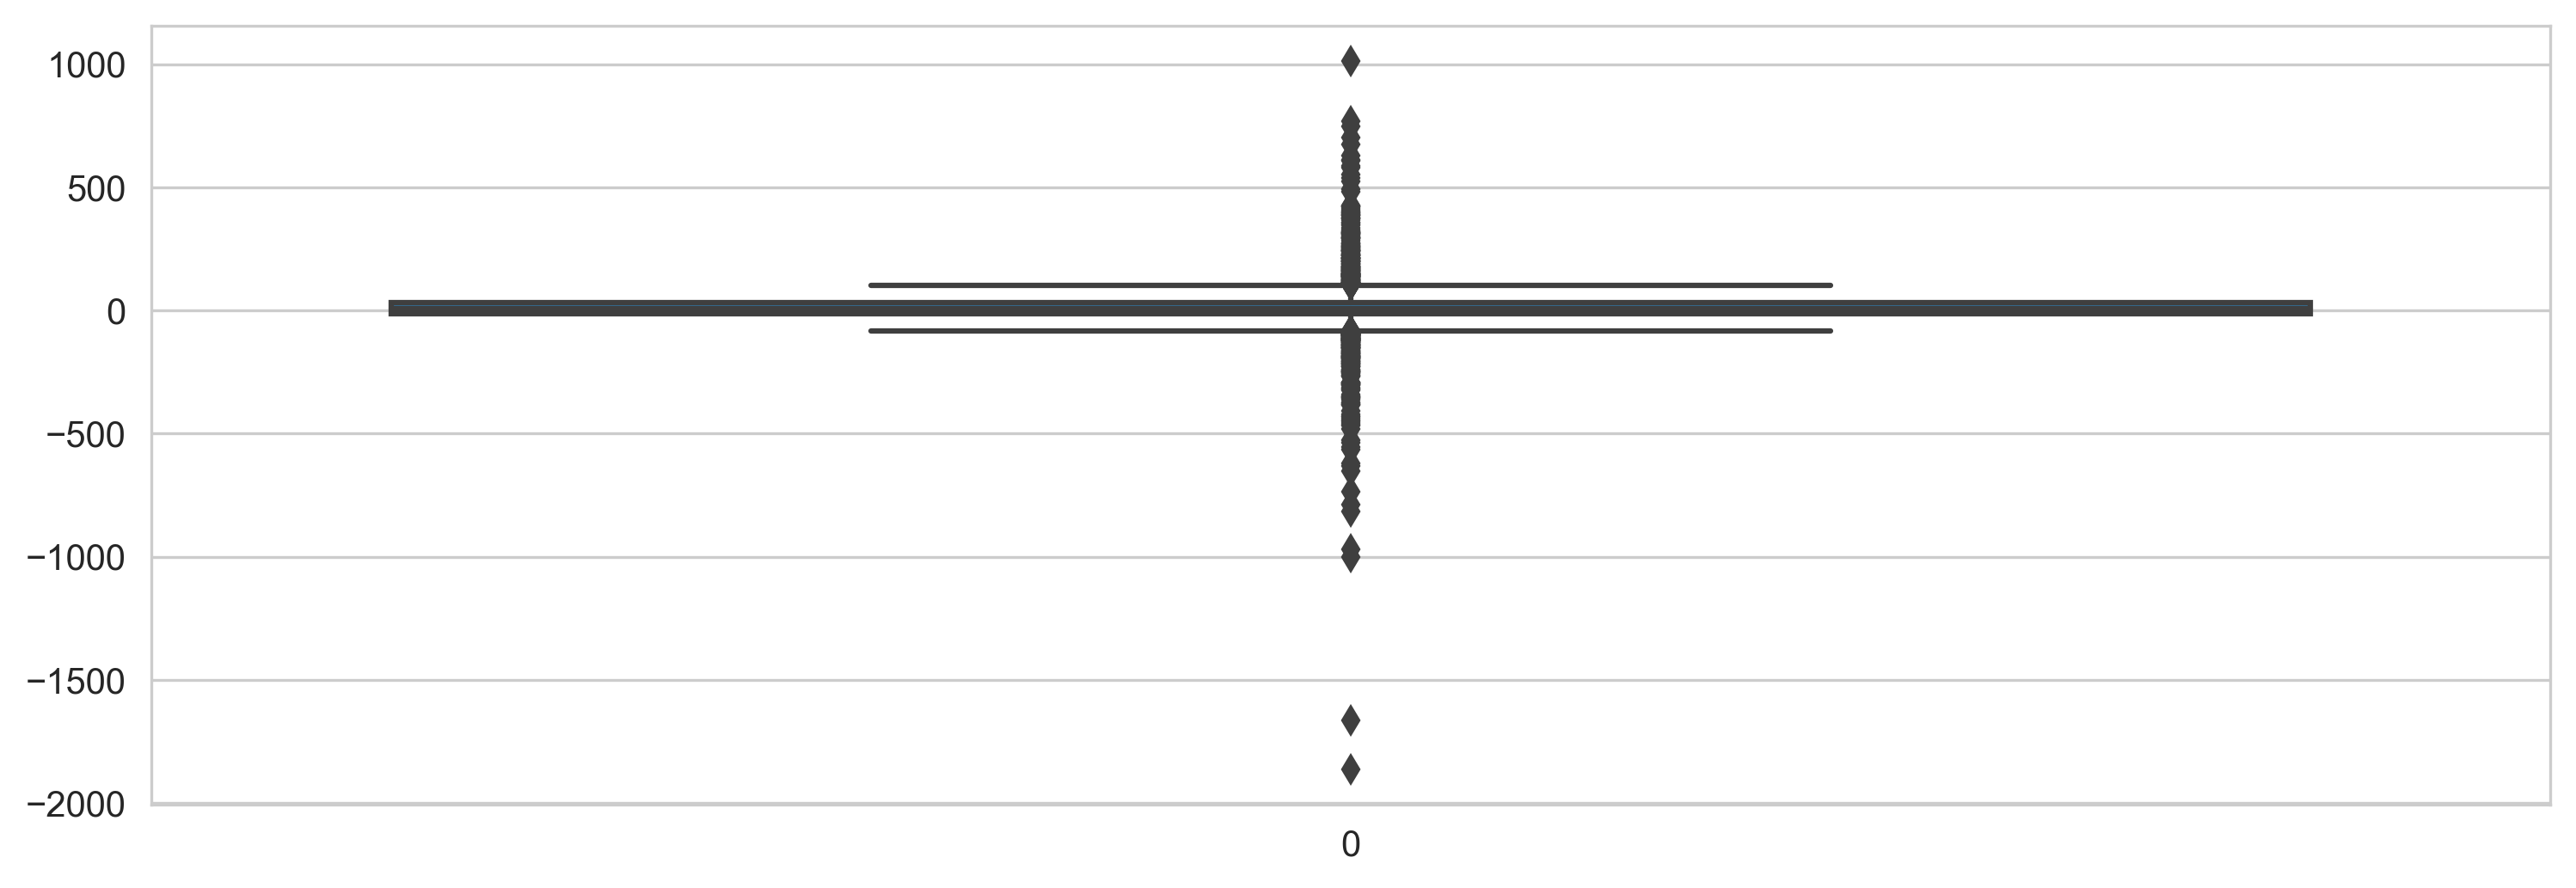

In [74]:
sns.boxplot(data=df['Profit']);

#### Overall Sales vs Profit of each year

In [75]:
df['Year'] = df['Order Date'].dt.year
df['Month'] = df['Order Date'].dt.month
df['Quarter'] = (df['Month']-1)//3+1

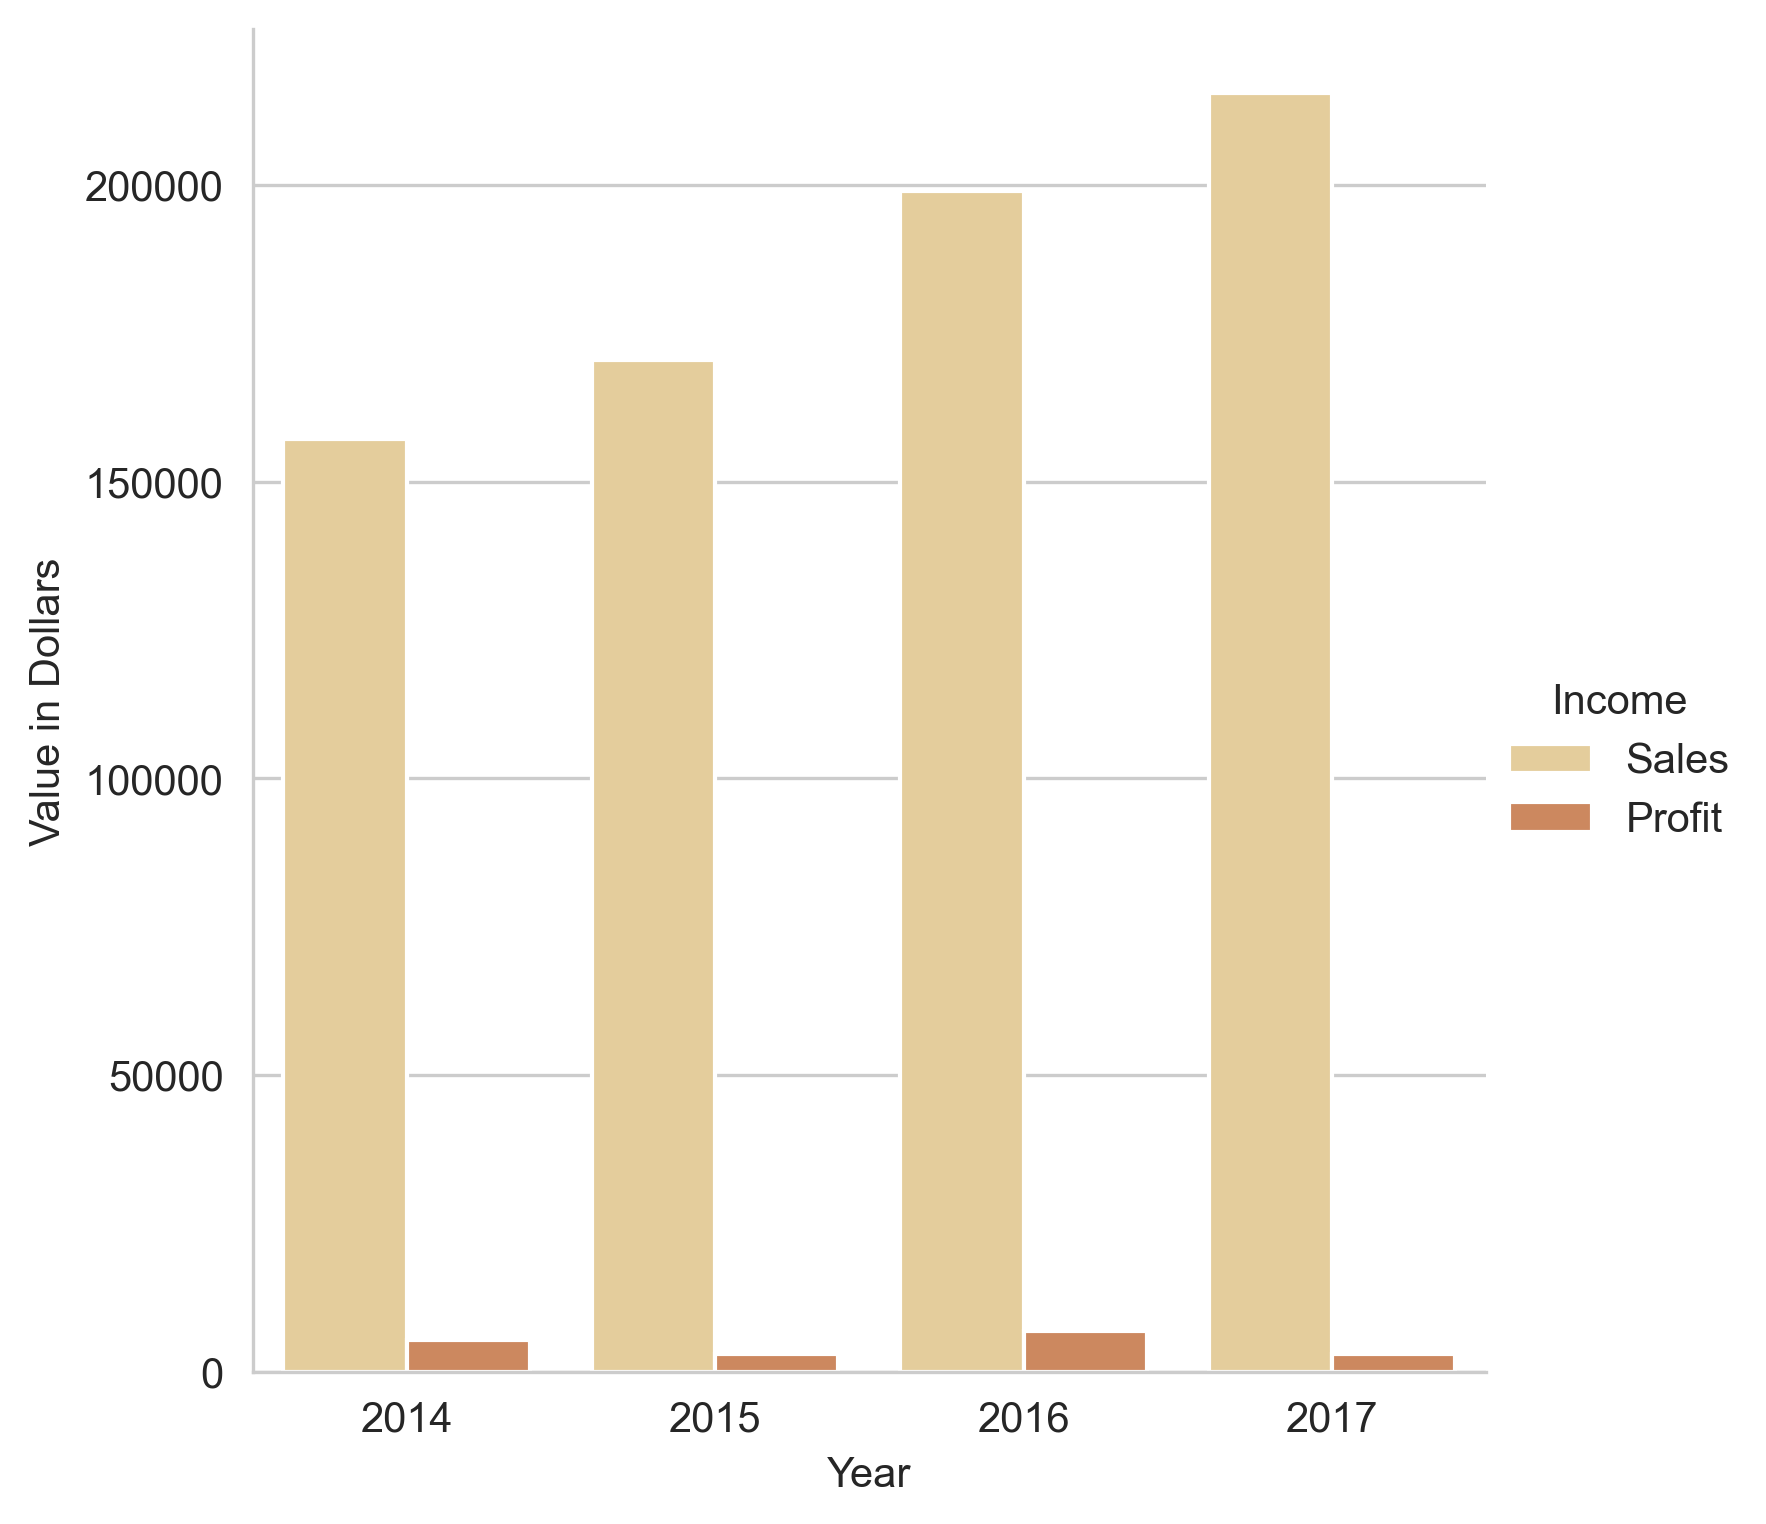

In [76]:
# calculate the Sales & Profit amounts of each Category
data = df.groupby(['Year'])[['Sales', 'Profit']].sum().reset_index()
data = pd.melt(data, id_vars='Year', var_name='Income', value_name='Value in Dollars')

# plot
sns.catplot(data=data, x='Year', y='Value in Dollars', hue='Income',  kind='bar', palette=colors);

#### Is the Sales column take into consideration the Quantity & Discount? 
Answer : Yes

In [77]:
df_ = df[df['Product ID'] == 'FUR-BO-10001798'][['Order Date', 'Product ID', 'Quantity', 'Sales', 'Discount']]
df_['Sales of Single Product'] = df_['Sales'] / df_['Quantity']
df_['Price of Single Product without Discount'] = df_['Sales of Single Product'] / (1 - df_['Discount'])
df_

Order Date       Product ID  Quantity    Sales  Discount  \
0    2016-11-08  FUR-BO-10001798         2  261.960      0.00   
1121 2016-04-09  FUR-BO-10001798         5  556.665      0.15   
1837 2017-08-25  FUR-BO-10001798         2  130.980      0.50   
1976 2017-05-01  FUR-BO-10001798         3  314.352      0.20   

      Sales of Single Product  Price of Single Product without Discount  
0                     130.980                                    130.98  
1121                  111.333                                    130.98  
1837                   65.490                                    130.98  
1976                  104.784                                    130.98

#### Plotting SALES & NUMBER-OF-TRANSACTIONS for each quarter

In [78]:
# plotting function
def plot_per_quarter(data, x, y, clrs=colors):
    
    sns.barplot(data=data, x=x, y=y, palette=clrs);
    plt.xticks(rotation=75)
    plt.show()

In [79]:
# make a copy
df_ = df[['Sales', 'Year', 'Month', 'Quarter']].copy()
df_.rename({'Sales':'Furniture Sales'}, axis=1, inplace=True)

# calculating quarter column
# df_['Quarter'] = (df_['Month']-1)//3+1

# quarterly sales
df_qua = df_.groupby(['Year', 'Quarter'])[['Furniture Sales']].sum().sort_values(['Year', 'Quarter']).reset_index()
df_qua['Year Quarter'] = df_qua['Year'].astype(str) + ' / ' + df_qua['Quarter'].astype(str)

# monthly sales
df_mon = df_.groupby(['Year', 'Month'])[['Furniture Sales']].sum().sort_values(by=['Year', 'Month']).reset_index()
df_mon['Year Month'] = df_mon['Year'].astype(str) + ' / ' + df_mon['Month'].astype(str)

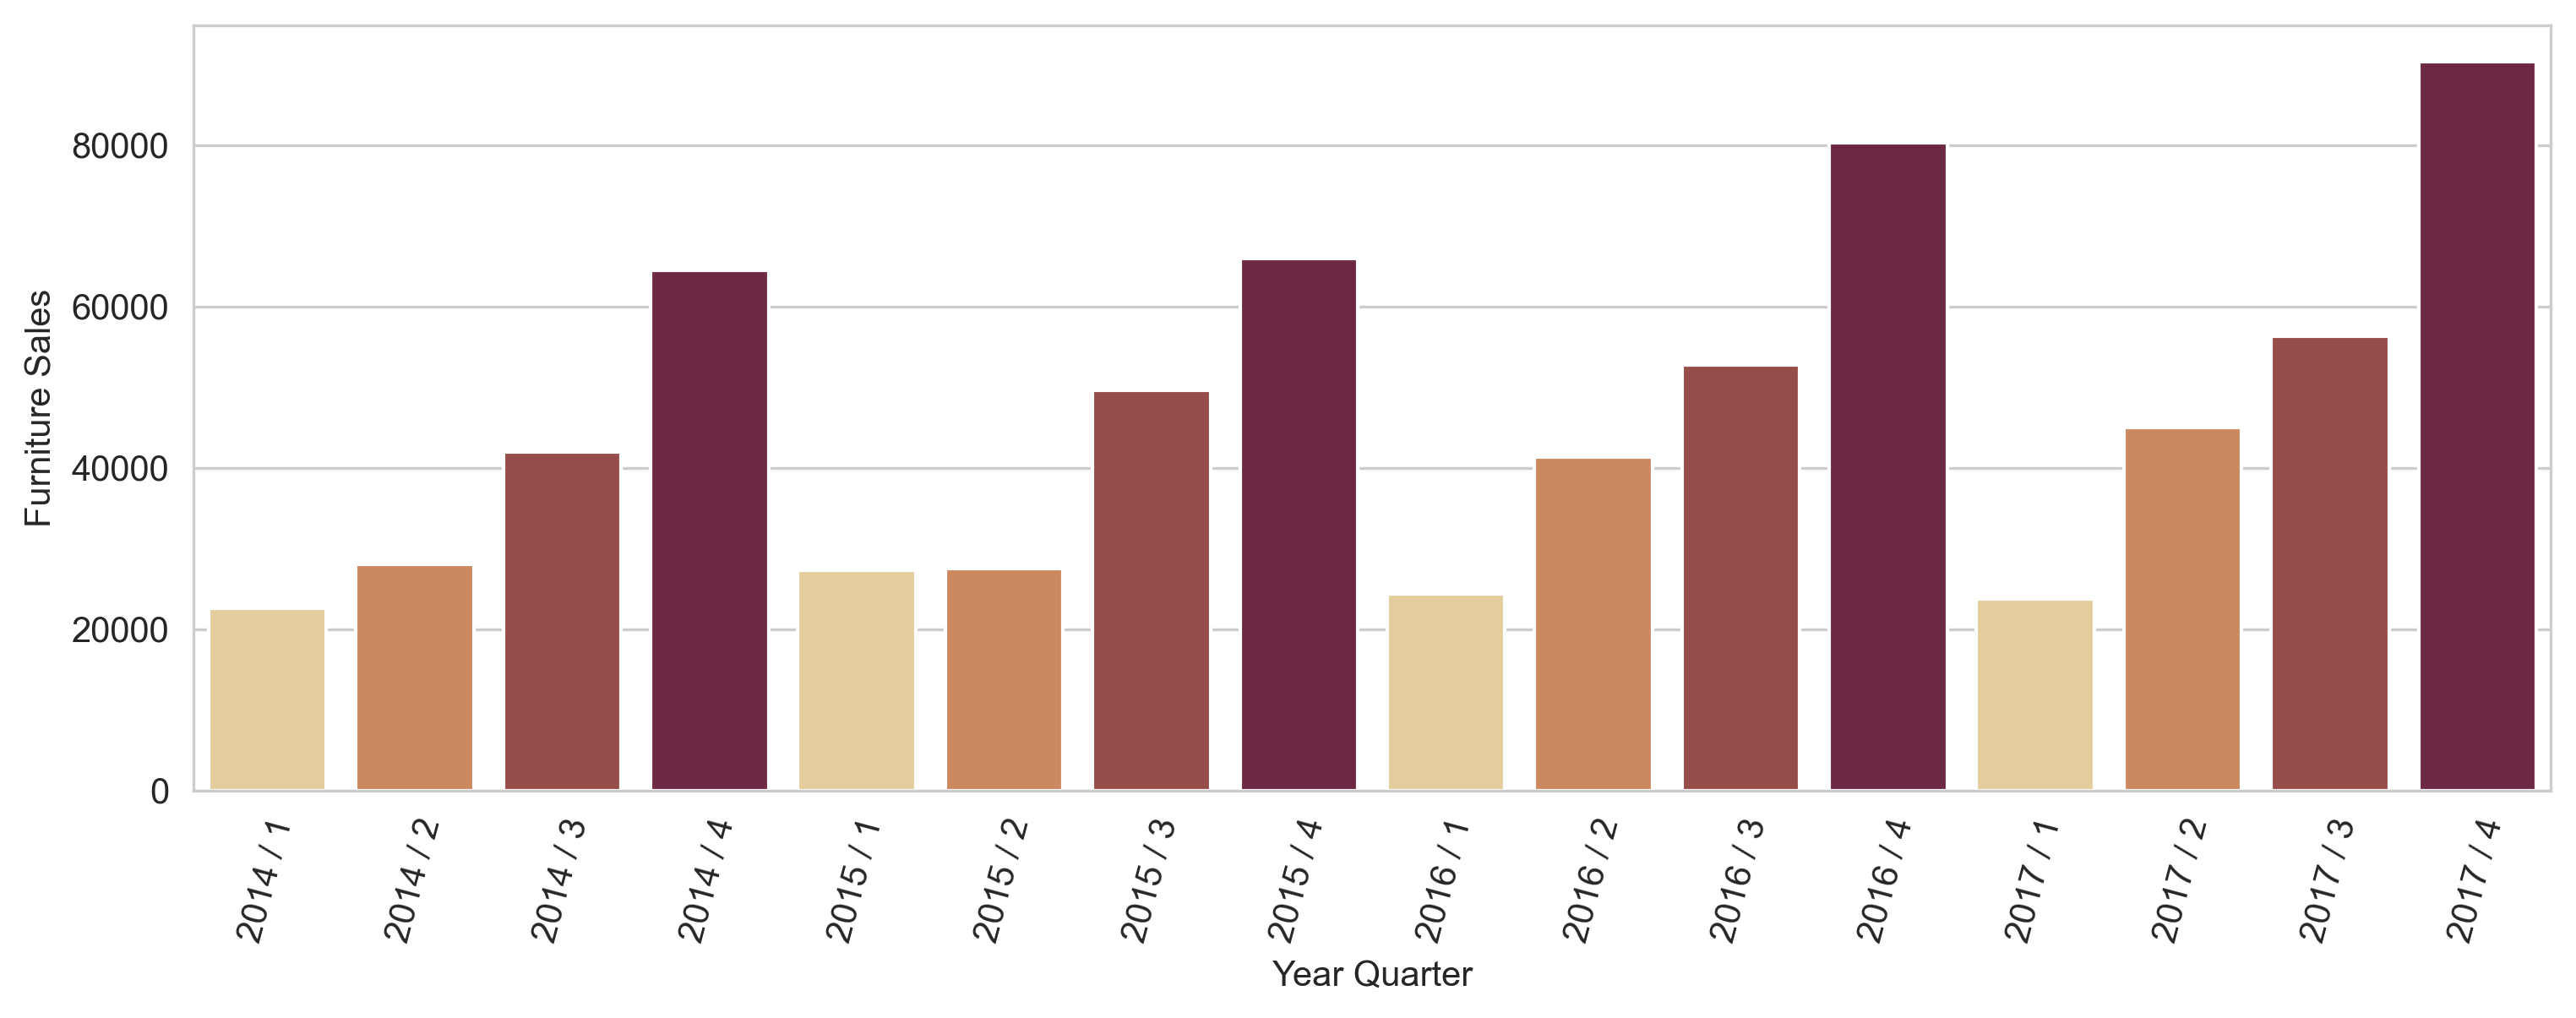

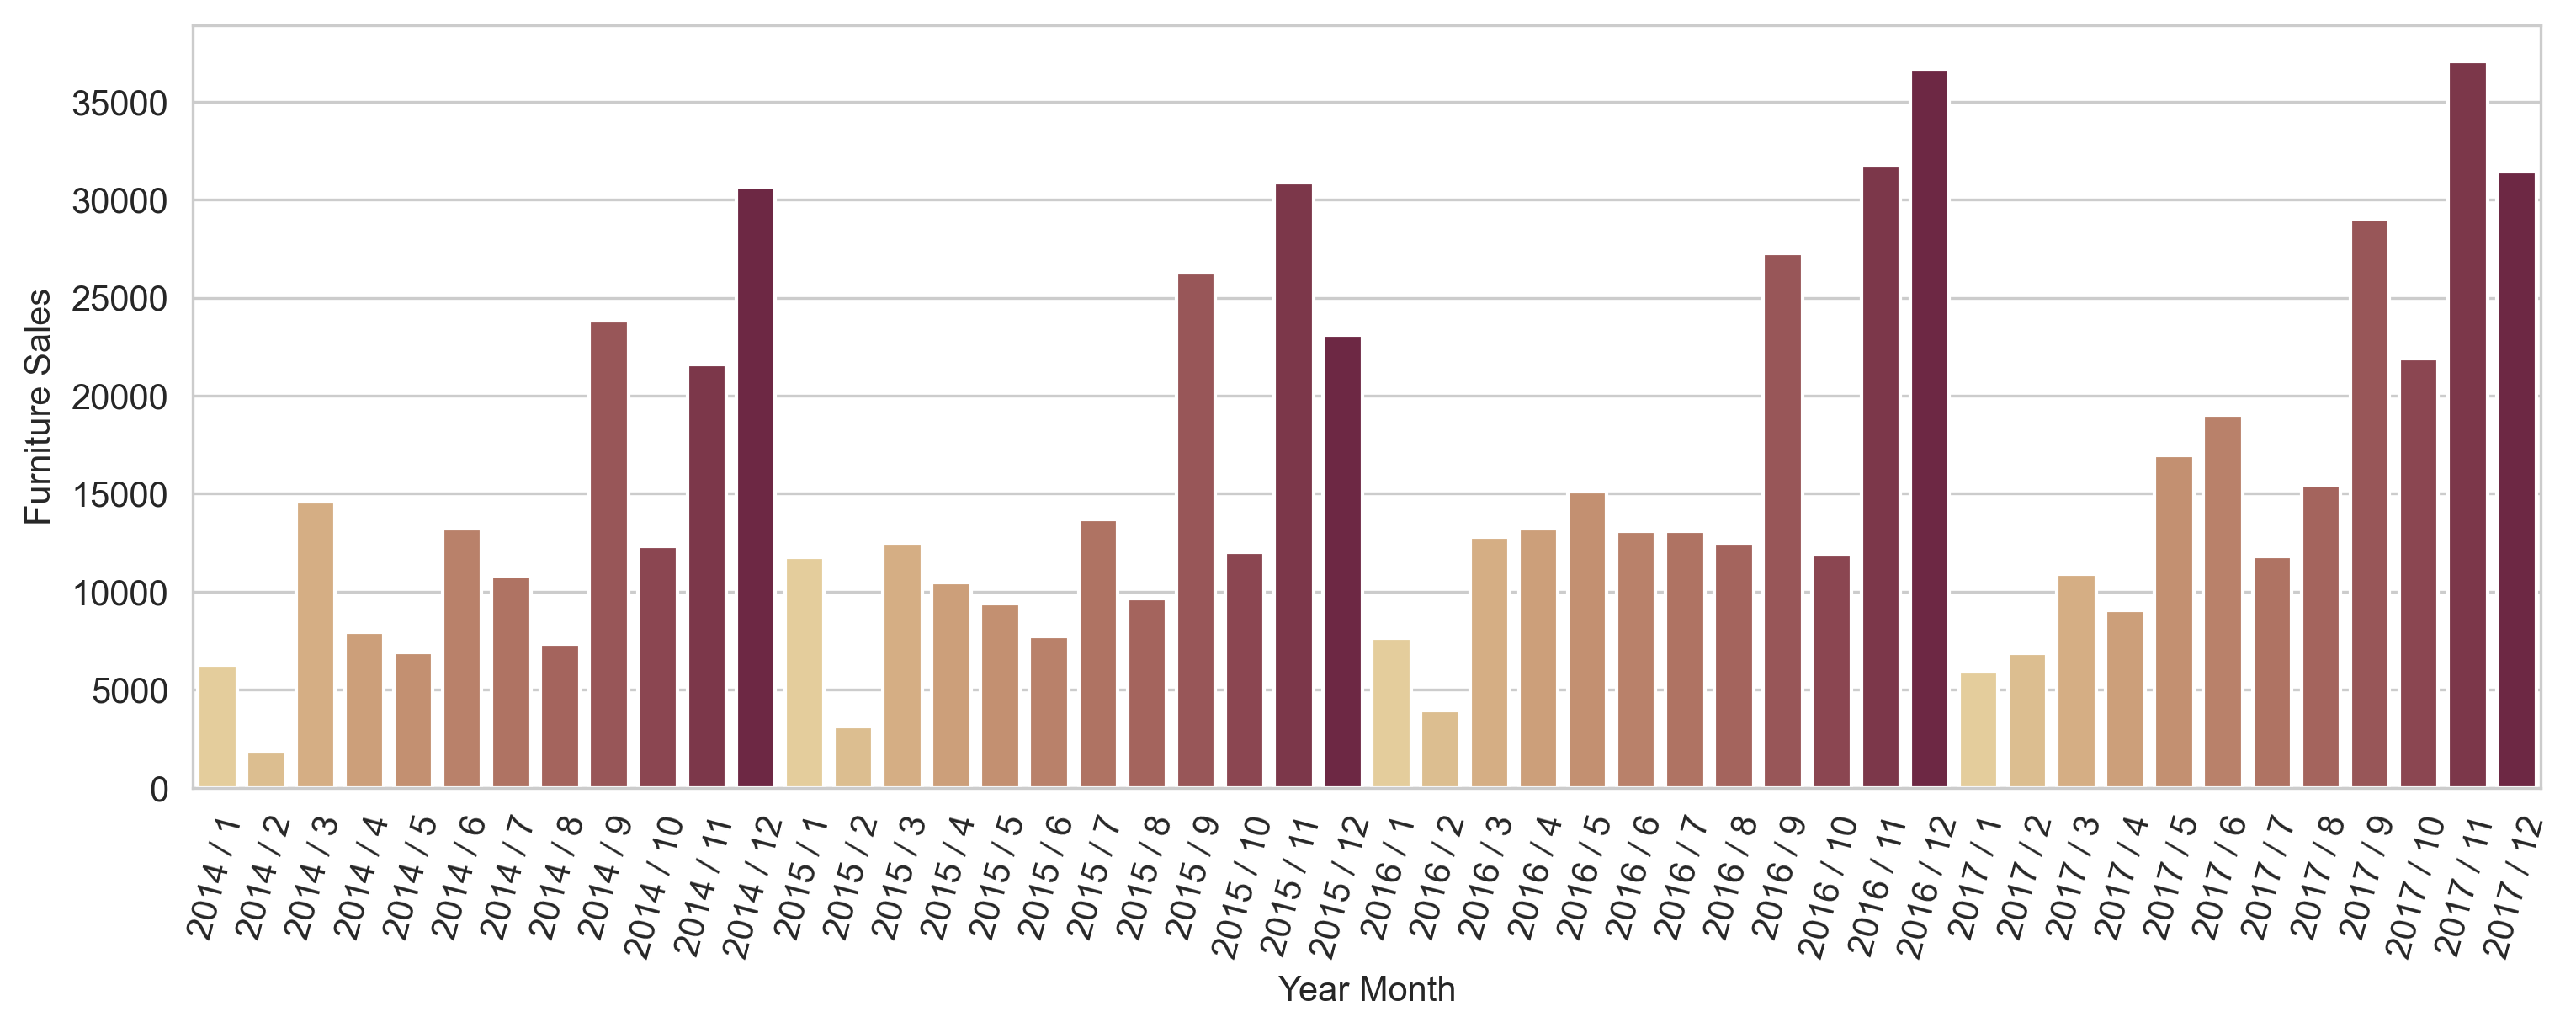

In [80]:
# plot 
plot_per_quarter(data=df_qua, x='Year Quarter', y='Furniture Sales')
# plot
plot_per_quarter(data=df_mon, x='Year Month', y='Furniture Sales', clrs=colors2)

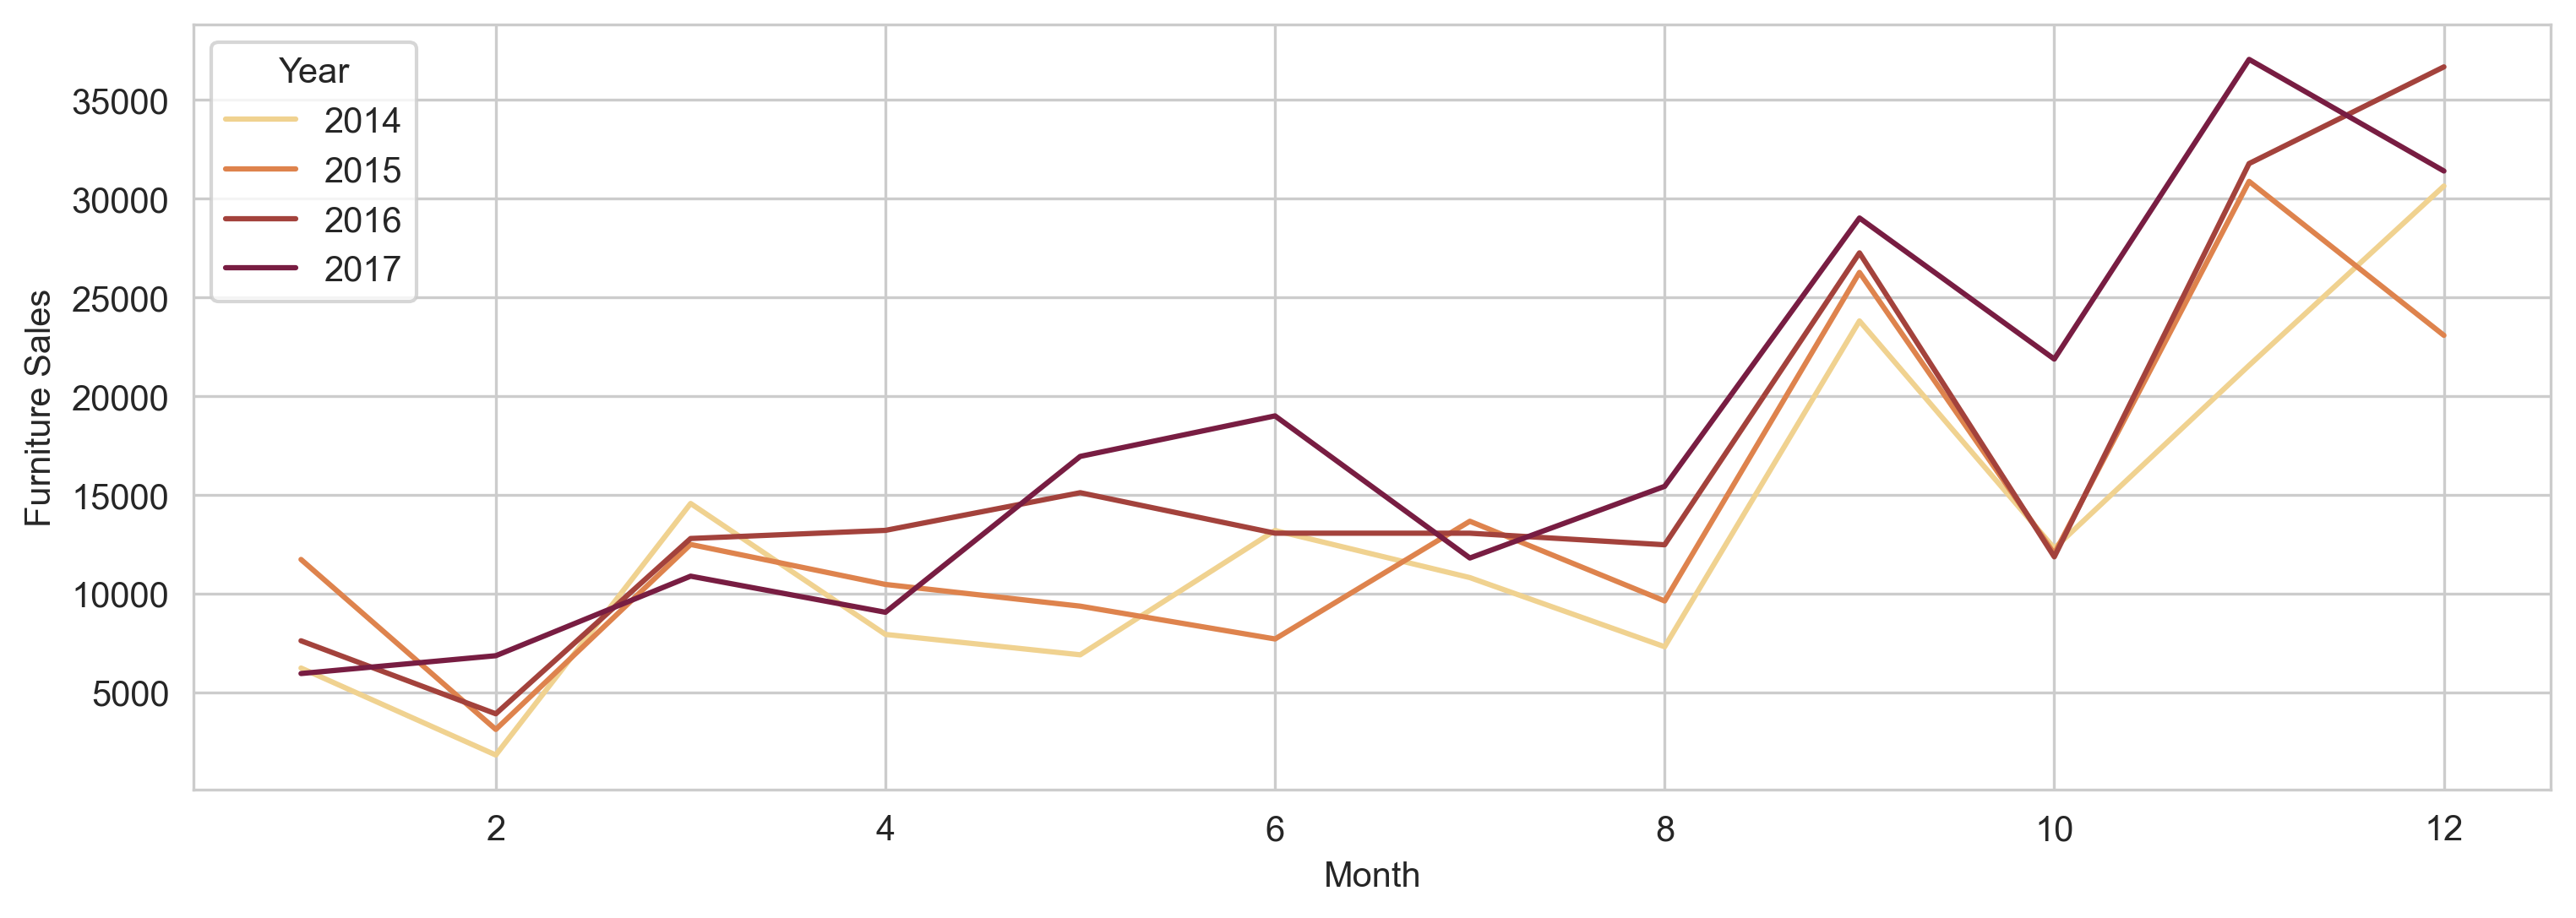

In [81]:
# plot
sns.lineplot(data=df_mon, x='Month', y='Furniture Sales', hue='Year', palette=colors);

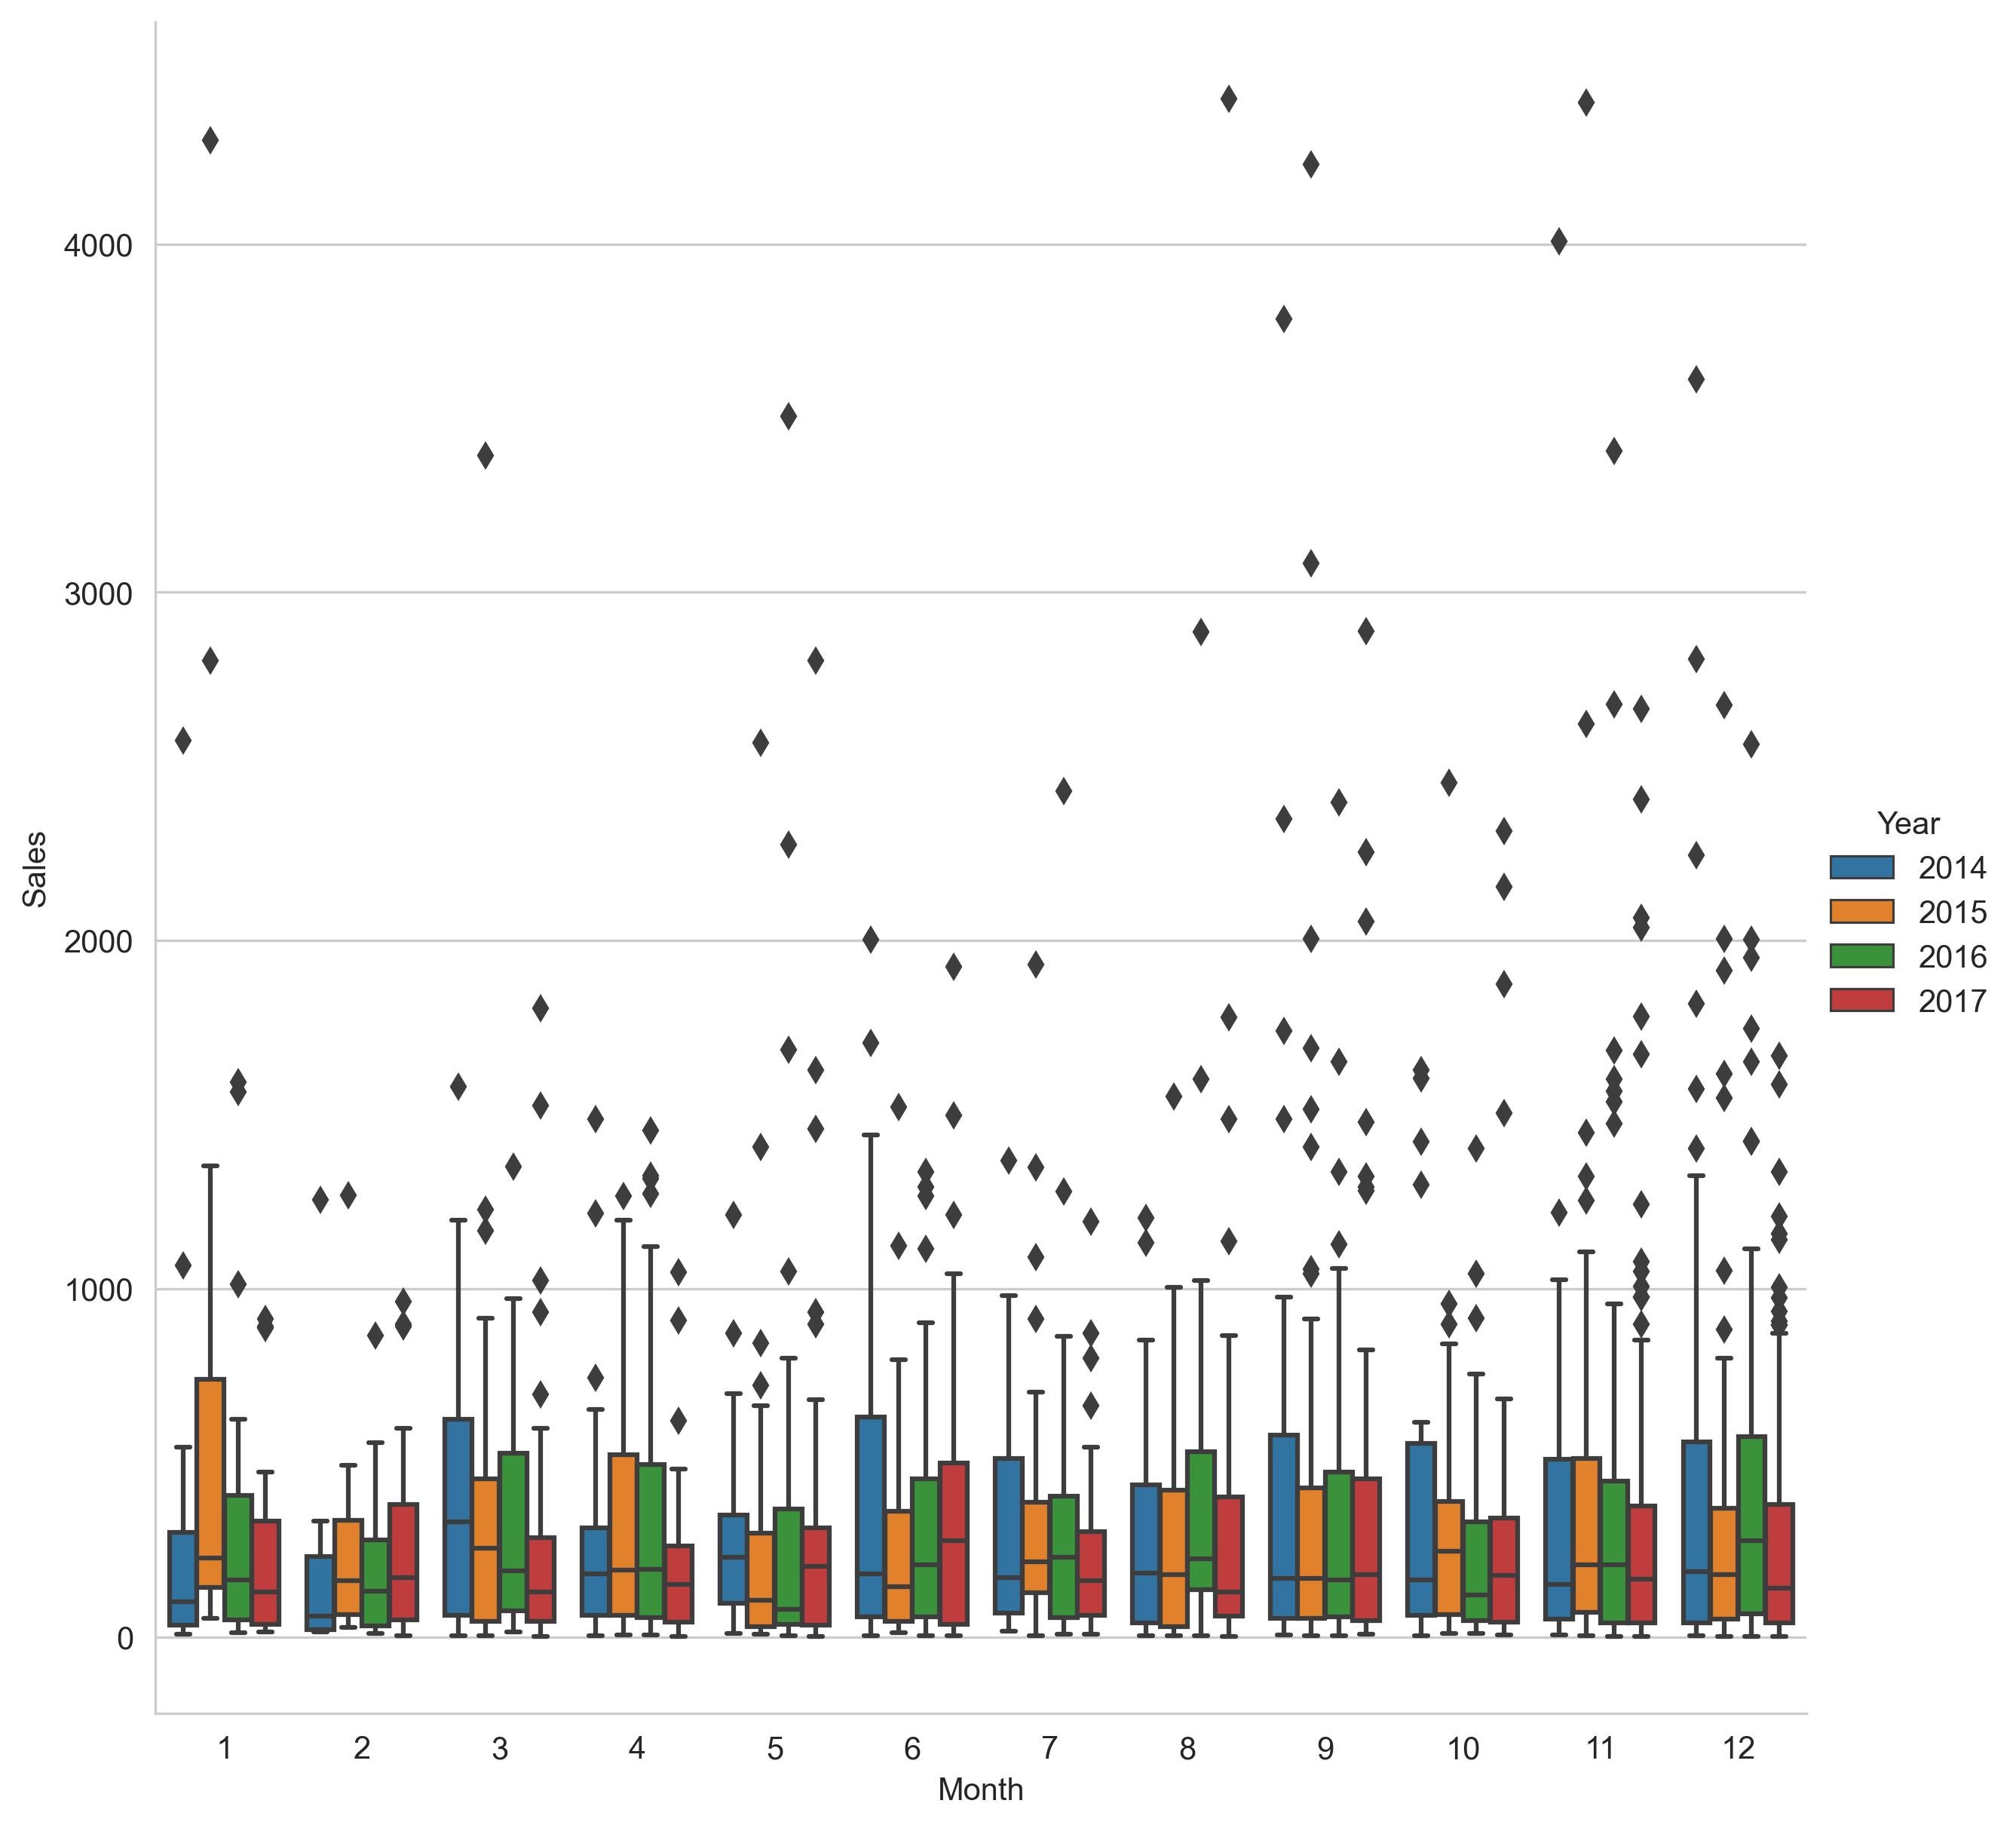

In [82]:
sns.catplot(
    hue='Year',
    x='Month',
    y='Sales',
    data=df,
    kind='box',
    height=8);

In [83]:
# # 
# df_ = df[df['Category'] == 'Furniture'].groupby(['Year', 'Quarter'])[['Sales', 'Profit']].agg(
#     Sales=('Sales', 'sum'), 
#     Profit=('Profit','sum'),
#     Number_of_Transactions=('Profit', 'count')).sort_values(['Year', 'Quarter']).reset_index()
# df_['index'] = df_['Year'].astype(str)  + ' Q' + df_['Quarter'].astype(str)

# # 
# li = df_[['index', 'Sales', 'Profit', 'Number_of_Transactions']].to_numpy()
# li_x = []
# li_y = []
# for row in li:
    
#     li_x.append('')
#     li_x.append(row[0] + ' Sales')
#     li_x.append(row[0] + ' Profit')
#     li_x.append(row[0] + ' Number_of_Transactions')
    
#     li_y.append(0)
#     li_y.append(row[1])    
#     li_y.append(row[2])    
#     li_y.append(row[3])  
    
# df_ = pd.DataFrame({'index':li_x, 'values':li_y})

## Data Preprocessing

#### Drop unnecessary columns

In [84]:
# monthly Furniture Sales
# df_ = df[['Order Date', 'Sales']].sort_values('Order Date')
# df_['Order Date'] = [d.replace(day=1) for d in df_['Order Date']]
# df_ = df_.groupby(['Order Date'])[['Sales']].sum().sort_values(['Order Date'])
# df_

In [106]:
# # monthly Furniture Sales
# df_ = df.groupby(['Year', 'Month'])[['Sales']].sum().reset_index().sort_values(['Year', 'Month'])
# df_['Year Month'] = df_['Year'].astype(str) + ' ' + df_['Month'].astype(str)
# df_ = df_.drop(['Year', 'Month'], axis=1).set_index('Year Month')
# df_

In [107]:
# # daily Furniture Sales
# df_ = df[['Order Date', 'Sales']].sort_values('Order Date').set_index('Order Date')
# df_

In [413]:
df_ = df[['Order Date', 'Sales']].sort_values('Order Date').set_index('Order Date')
df_ = df_.Sales.resample('W').mean()
df_ = df_.to_frame()
df_

Sales
Order Date            
2014-01-12  678.107000
2014-01-19  250.094600
2014-01-26  183.995333
2014-02-02  311.833000
2014-02-09   14.560000
...                ...
2017-12-03  500.255375
2017-12-10  314.085857
2017-12-17  244.201000
2017-12-24  330.638318
2017-12-31  224.309156

[208 rows x 1 columns]

#### Split data into TRAIN & TEST 

In [201]:
# to split dataet into training and test datasets by specifying date split point
def split_int_train_test(df_, date_split):
    df_ = df_.reset_index()
    return (df_[df_['Order Date'] < date_split].set_index('Order Date'), 
            df_[df_['Order Date'] >= date_split].set_index('Order Date'))

In [202]:
# split into TRAIN and TEST
df_train, df_test = split_int_train_test(df_, datetime.datetime(2017, 1, 1))

In [203]:
print(f'train dataset shape: {df_train.shape}')
print(f'test  dataset shape: {df_test.shape}')

train dataset shape: (155, 1)
test  dataset shape: (53, 1)


## Model Selection

#### Baseline

In [248]:
# 01
values = pd.DataFrame(df_['Sales'].values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
print(dataframe.head(5))

          t-1         t+1
0         NaN  678.107000
1  678.107000  250.094600
2  250.094600  183.995333
3  183.995333  311.833000
4  311.833000   14.560000


In [249]:
# 02
# split into train and test sets
X = dataframe.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

In [250]:
# 03
# persistence model
def model_persistence(x):
    return x

In [278]:
# 04
# walk-forward validation
predictions = list()
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)

print('Test MSE: %.3f' % mean_squared_error(test_y, predictions))
print('Test R2 Score: %.3f' % r2_score(y_test, y_pred))


Test MSE: 38613.486
Test R2 Score: -0.020


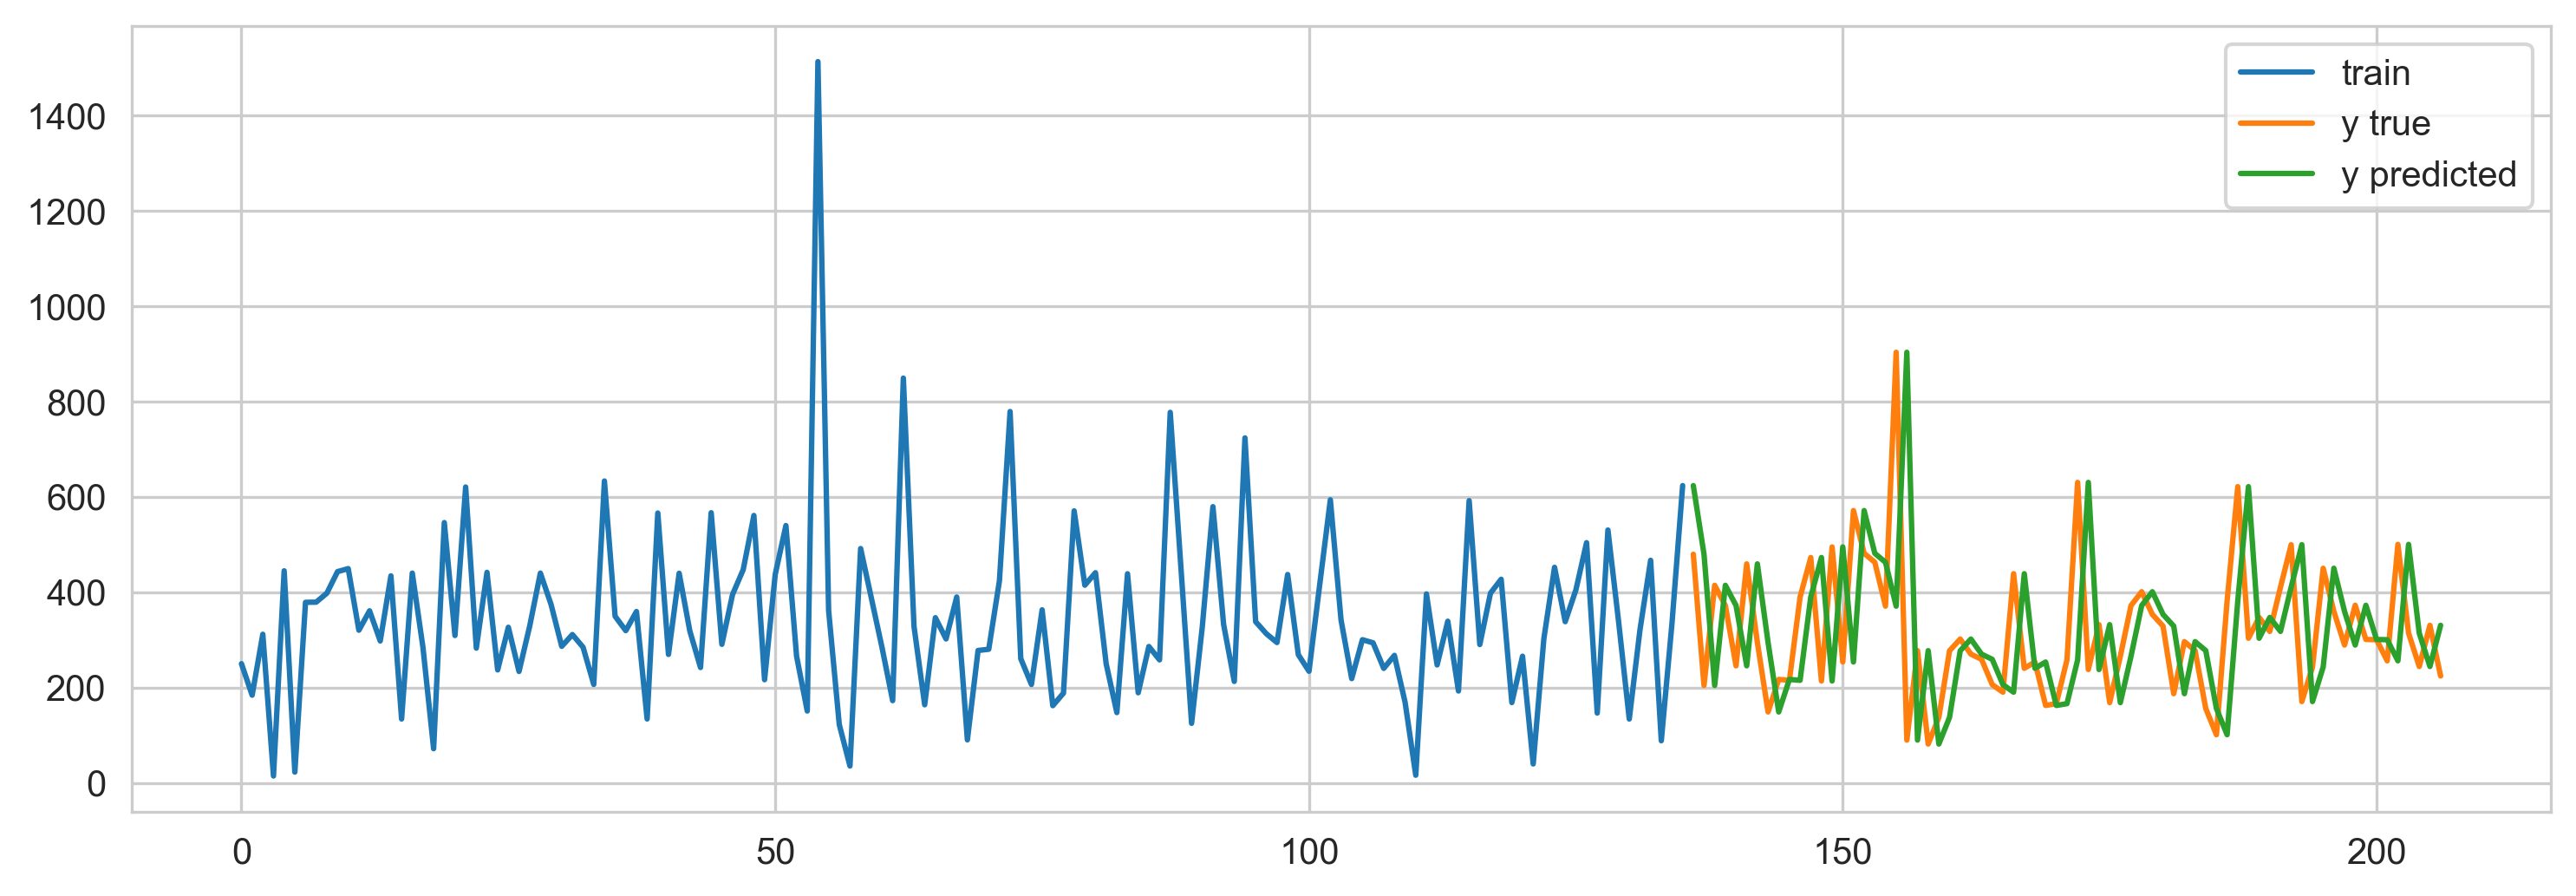

In [252]:
# 05
# plot predictions and expected results
plt.plot(train_y)
plt.plot([None for i in train_y] + [x for x in test_y])
plt.plot([None for i in train_y] + [x for x in predictions])
plt.legend(['train', 'y true', 'y predicted'])
plt.show()

#### Baseline 2

In [334]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Lag

df_['L1'] = df_['Sales'].shift(1)
df_['L2'] = df_['Sales'].shift(2)
df_['L3'] = df_['Sales'].shift(3)
df_['L4'] = df_['Sales'].shift(4)
df_['L5'] = df_['Sales'].shift(5)
df_['L6'] = df_['Sales'].shift(6)
df_['L7'] = df_['Sales'].shift(7)
df_ = df_.dropna(how='any')
df_

Sales          L1          L2          L3          L4  \
Order Date                                                               
2014-03-02  378.799000   22.740000  444.904500   14.560000  311.833000   
2014-03-09  379.157200  378.799000   22.740000  444.904500   14.560000   
2014-03-16  397.978667  379.157200  378.799000   22.740000  444.904500   
2014-03-23  443.197333  397.978667  379.157200  378.799000   22.740000   
2014-03-30  449.483286  443.197333  397.978667  379.157200  378.799000   
...                ...         ...         ...         ...         ...   
2017-12-03  500.255375  256.107259  300.318125  300.884095  372.645217   
2017-12-10  314.085857  500.255375  256.107259  300.318125  300.884095   
2017-12-17  244.201000  314.085857  500.255375  256.107259  300.318125   
2017-12-24  330.638318  244.201000  314.085857  500.255375  256.107259   
2017-12-31  224.309156  330.638318  244.201000  314.085857  500.255375   

                    L5          L6          L7  
Order Date                                      
2014-03-02  183.995333  250.094600  678.107000  
2014-03-09  311.833000  183.995333  250.094600  
2014-03-16   14.560000  311.833000  183.995333  
2014-03-23  444.904500   14.560000  311.833000  
2014-03-30   22.740000  444.904500   14.560000  
...                ...         ...         ...  
2017-12-03  289.184800  359.849950  450.233000  
2017-12-10  372.645217  289.184800  359.849950  
2017-12-17  300.884095  372.645217  289.184800  
2017-12-24  300.318125  300.884095  372.645217  
2017-12-31  256.107259  300.318125  300.884095  

[201 rows x 8 columns]

In [335]:
# Split 
X_train, X_test, y_train, y_test = train_test_split(df_.drop(['Sales'], axis=1), df_['Sales'], test_size=0.33, random_state=42)

In [370]:
X_test

L1          L2          L3          L4          L5  \
Order Date                                                               
2015-12-27  234.257429  268.908182  437.122043  294.461393  313.024533   
2014-06-15  309.183500  546.052714   71.821000  284.549000  440.037143   
2014-09-28  349.586500  633.294222  206.574111  284.615700  311.196000   
2017-03-12  259.292800  270.104571  301.780044  277.220714  137.559286   
2016-08-14   88.525333  466.946000  320.711333  134.098286  338.340900   
...                ...         ...         ...         ...         ...   
2014-10-05  319.435180  349.586500  633.294222  206.574111  284.615700   
2014-05-25  284.549000  440.037143  134.128800  434.275000  297.761333   
2014-11-02  269.538000  566.079750  134.183667  359.489750  319.435180   
2016-06-12  338.236923  452.195091  302.476750   39.865333  265.729143   
2014-12-21  447.315321  395.099875  290.727133  566.752471  242.079606   

                    L6          L7  
Order Date                          
2015-12-27  338.220371  723.594765  
2014-06-15  134.128800  434.275000  
2014-09-28  286.504500  374.456571  
2017-03-12   81.587500  277.475286  
2016-08-14  530.418400  146.590250  
...                ...         ...  
2014-10-05  311.196000  286.504500  
2014-05-25  361.016200  320.288857  
2014-11-02  349.586500  633.294222  
2016-06-12  168.612333  427.194750  
2014-12-21  318.743273  439.775400  

[67 rows x 7 columns]

In [410]:
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_test, y_test)

y_pred = reg.predict(X_test)

# from sklearn.preprocessing import PolynomialFeatures
# poly_reg = PolynomialFeatures(degree=1)
# X_poly = poly_reg.fit_transform(X_train)
# pol_reg = LinearRegression()
# pol_reg.fit(X_poly, y_train)
# y_pred = pol_reg.predict(poly_reg.fit_transform(X_test))

print('Test MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('Test R2 Score: %.3f' % r2_score(y_test, y_pred))

Test MSE: 27237.033
Test R2 Score: -0.042


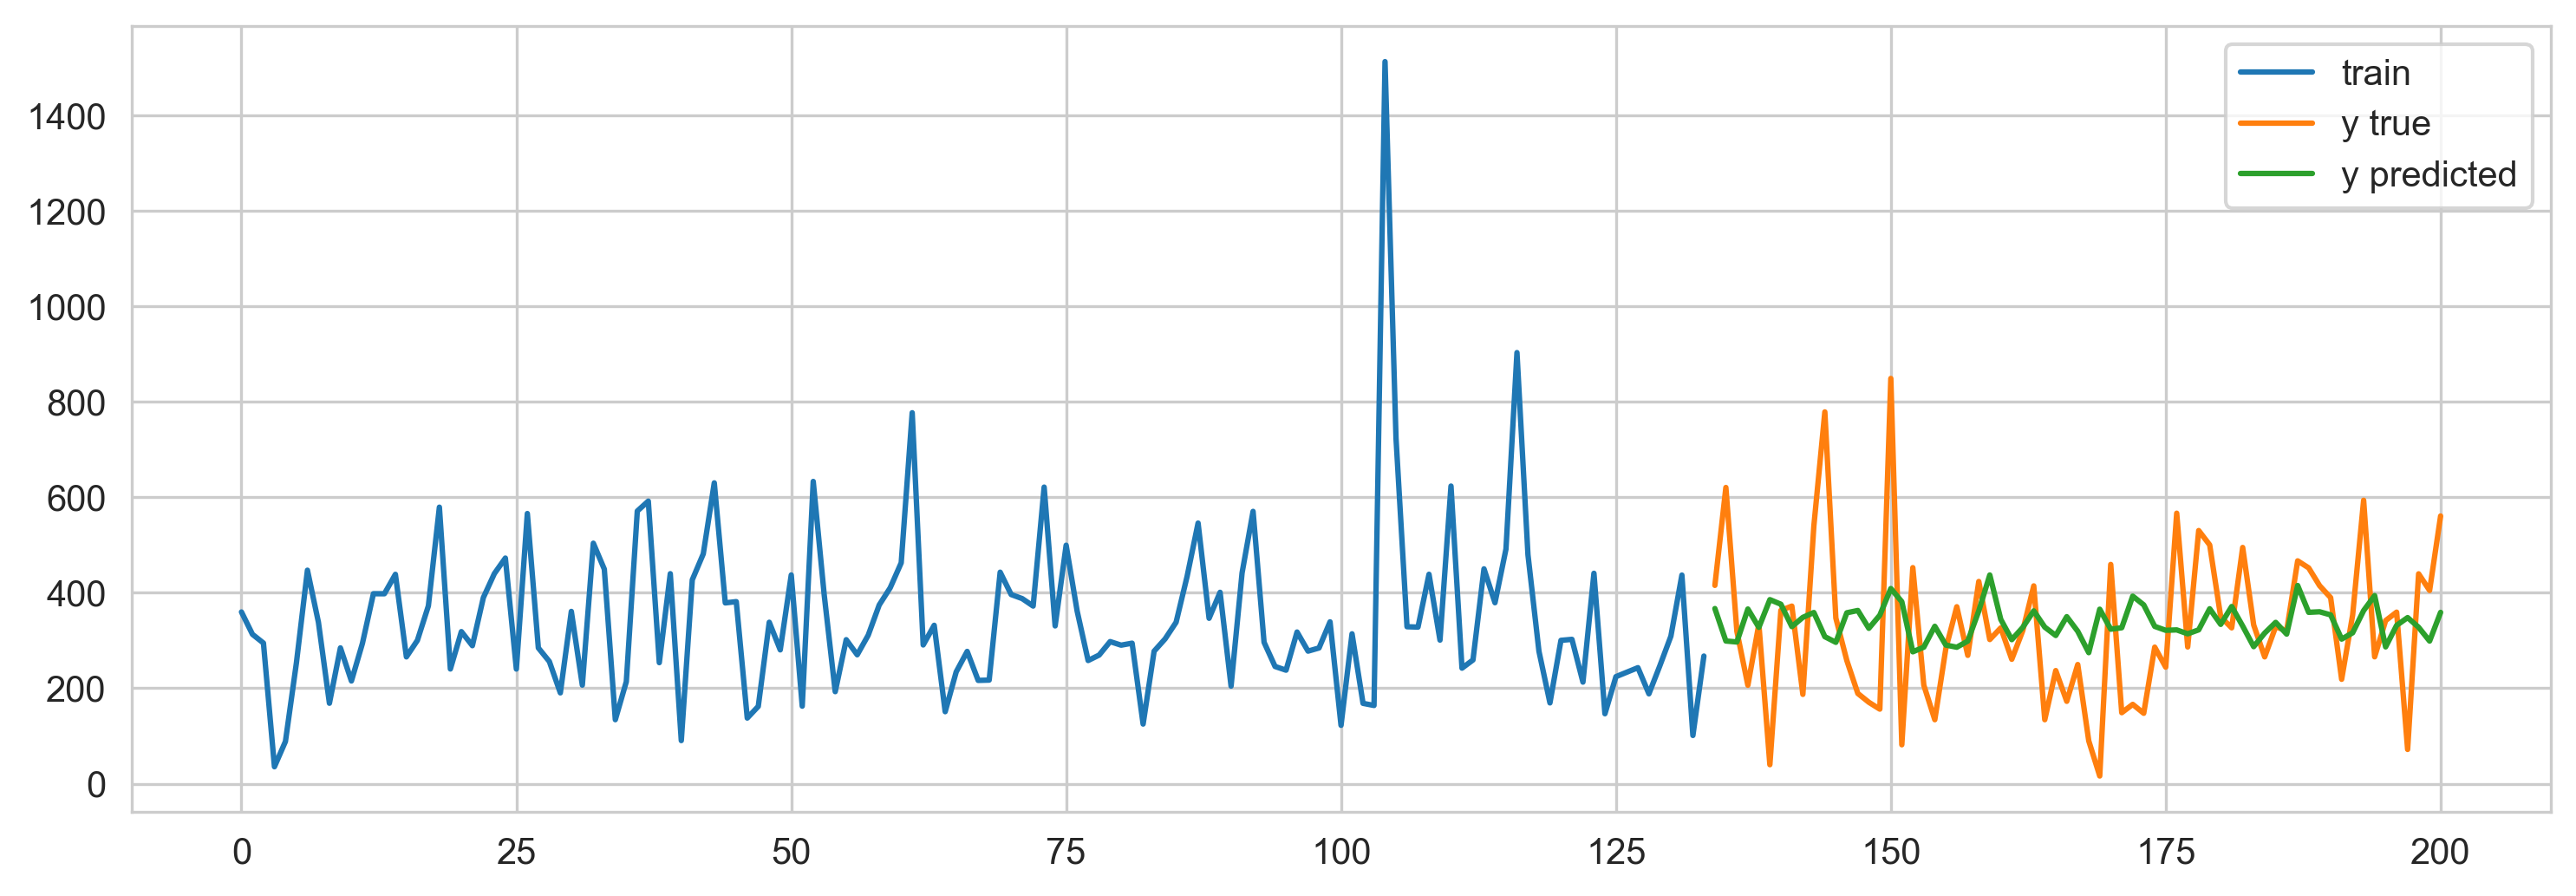

In [411]:
# plot predictions and expected results
plt.plot(y_train.to_list())
plt.plot([None for i in y_train] + [x for x in y_test])
plt.plot([None for i in y_train] + [x for x in y_pred])
plt.legend(['train', 'y true', 'y predicted'])
plt.show()

#### Method #01 : ARIMA

In [204]:
# # resample all store data to average daily sales
# daily_average_sales = df_.Sales.resample('D').mean()

# daily_average_sales.fillna(0, inplace=True);
# # daily_average_sales.isna().sum()
# daily_average_sales.head()

In [205]:
# # check autocorrelation for previous two weeks
# for i in range(1,16):
#     print(i, daily_average_sales.autocorr(lag=i))

In [206]:
# # check yearly autocorr
# for i in range(360,371):
#     print(i, daily_average_sales.autocorr(lag=i))
    
# # note the spike around 364-365

In [208]:
# # plot autocorrelation for different lags using pandas
# from pandas.plotting import autocorrelation_plot
# # plt.figure(figsize=(20,7))

# plt.rcParams['figure.dpi'] = 300
# autocorrelation_plot(daily_average_sales);
# # plt.xlim(0,100);


In [210]:
# # find rolling daily mean

# daily_average_sales.rolling(window=3, center=True).mean().plot(figsize=(12,4));

# # this gives us a bit of smoothing to exclude extreme events

Instead of plotting the full timeseries, we can plot the rolling mean instead, which smooths random changes in sales as well as removing outliers, helping us identify larger trends.

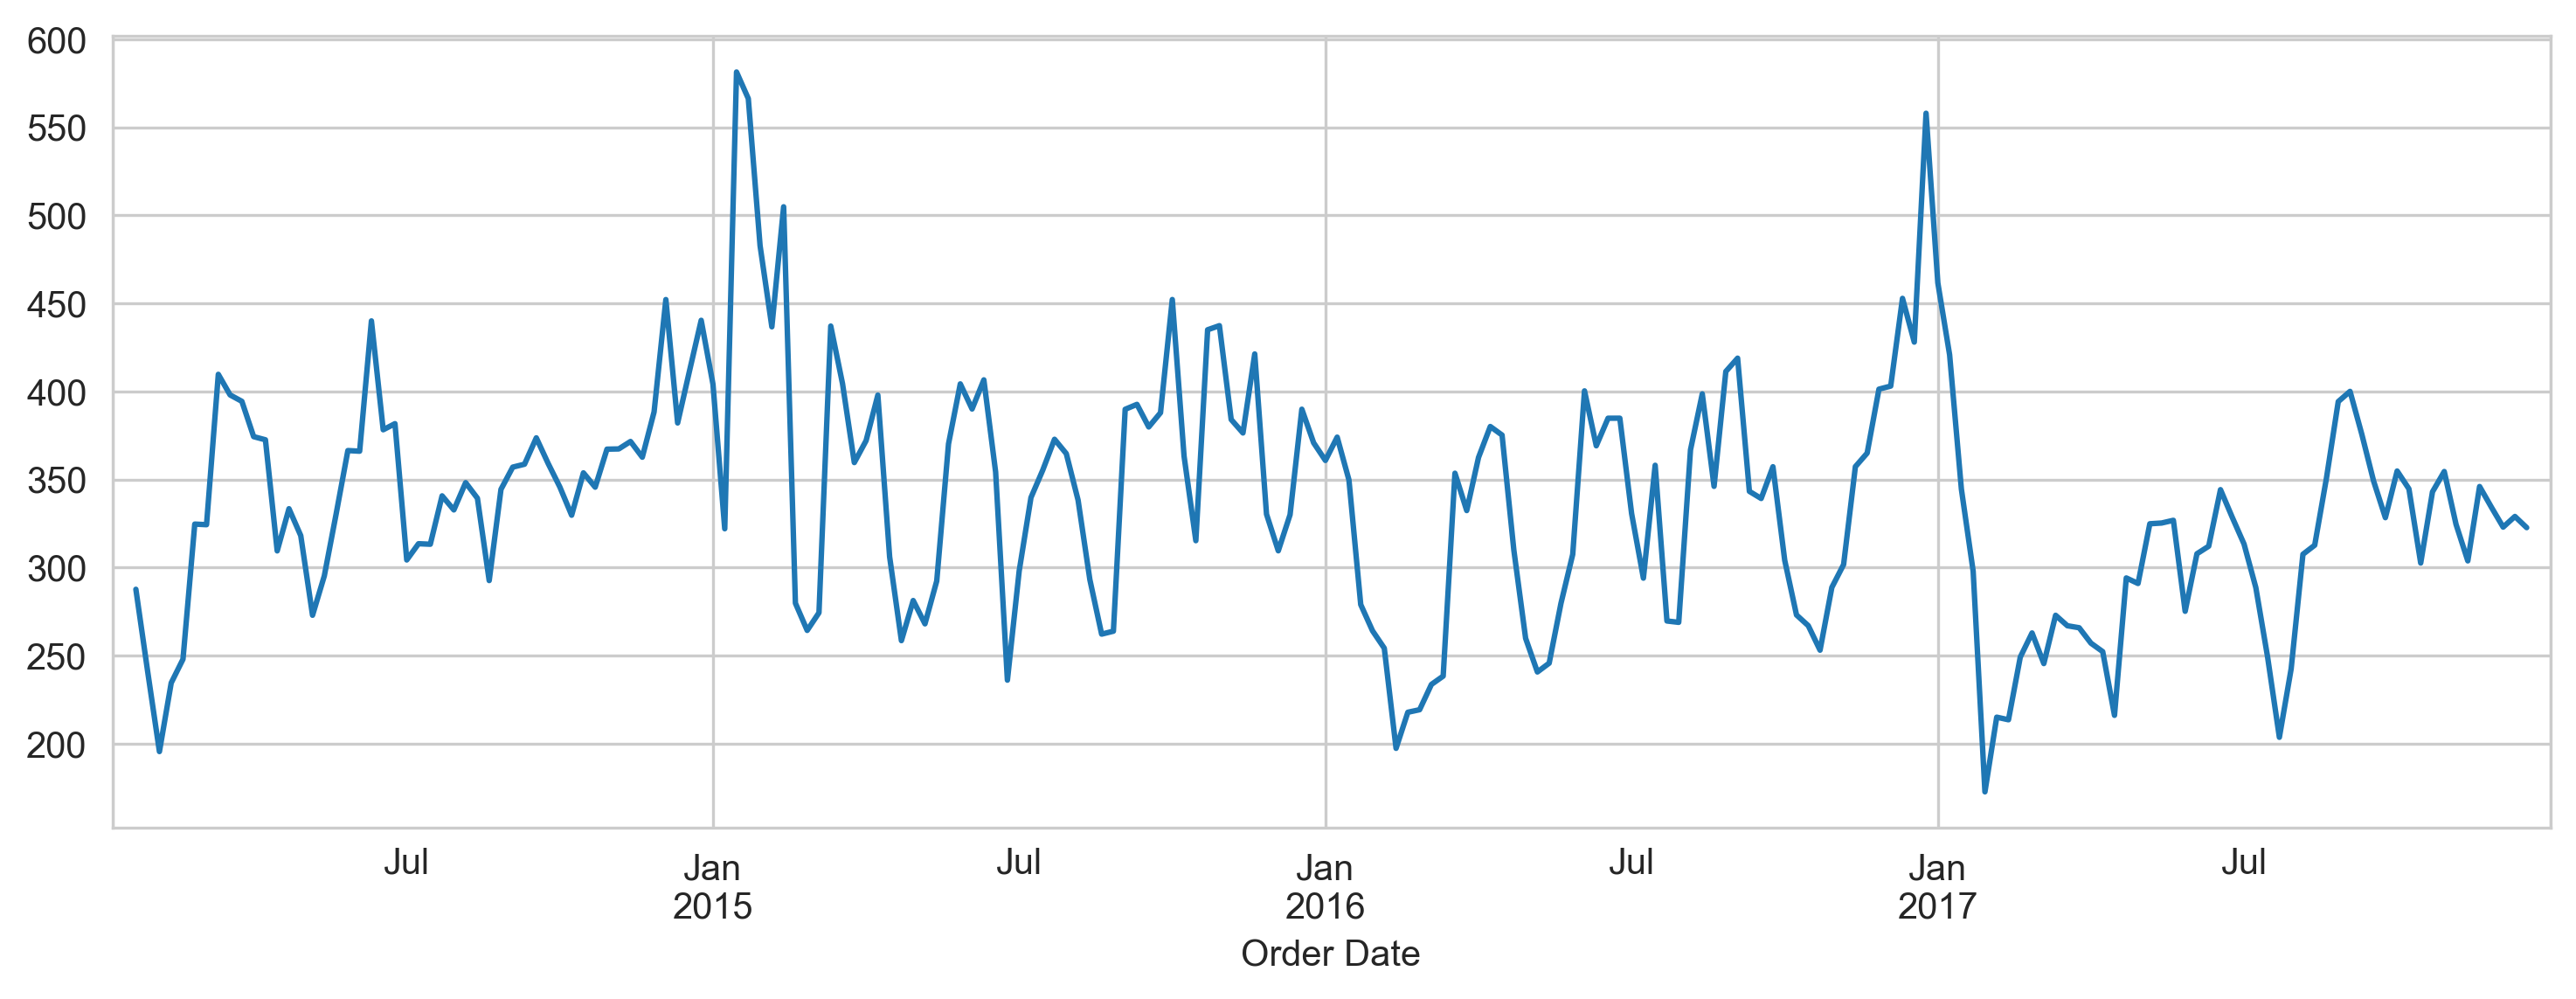

In [211]:
# plot 5-week centered rolling mean
weekly_average_sales = df_.Sales.resample('W').mean()
weekly_average_sales.rolling(window=5, center=True).mean().plot(figsize=(12,4));

In [212]:
# define helper plot function for visualization
import statsmodels.tsa.api as smt

def plots(data, lags=None):
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    data.plot(ax=raw, figsize=(12, 6))
    smt.graphics.plot_acf(data, lags=lags, ax=acf)
    smt.graphics.plot_pacf(data, lags=lags, ax=pacf)
    sns.despine()
    plt.tight_layout()

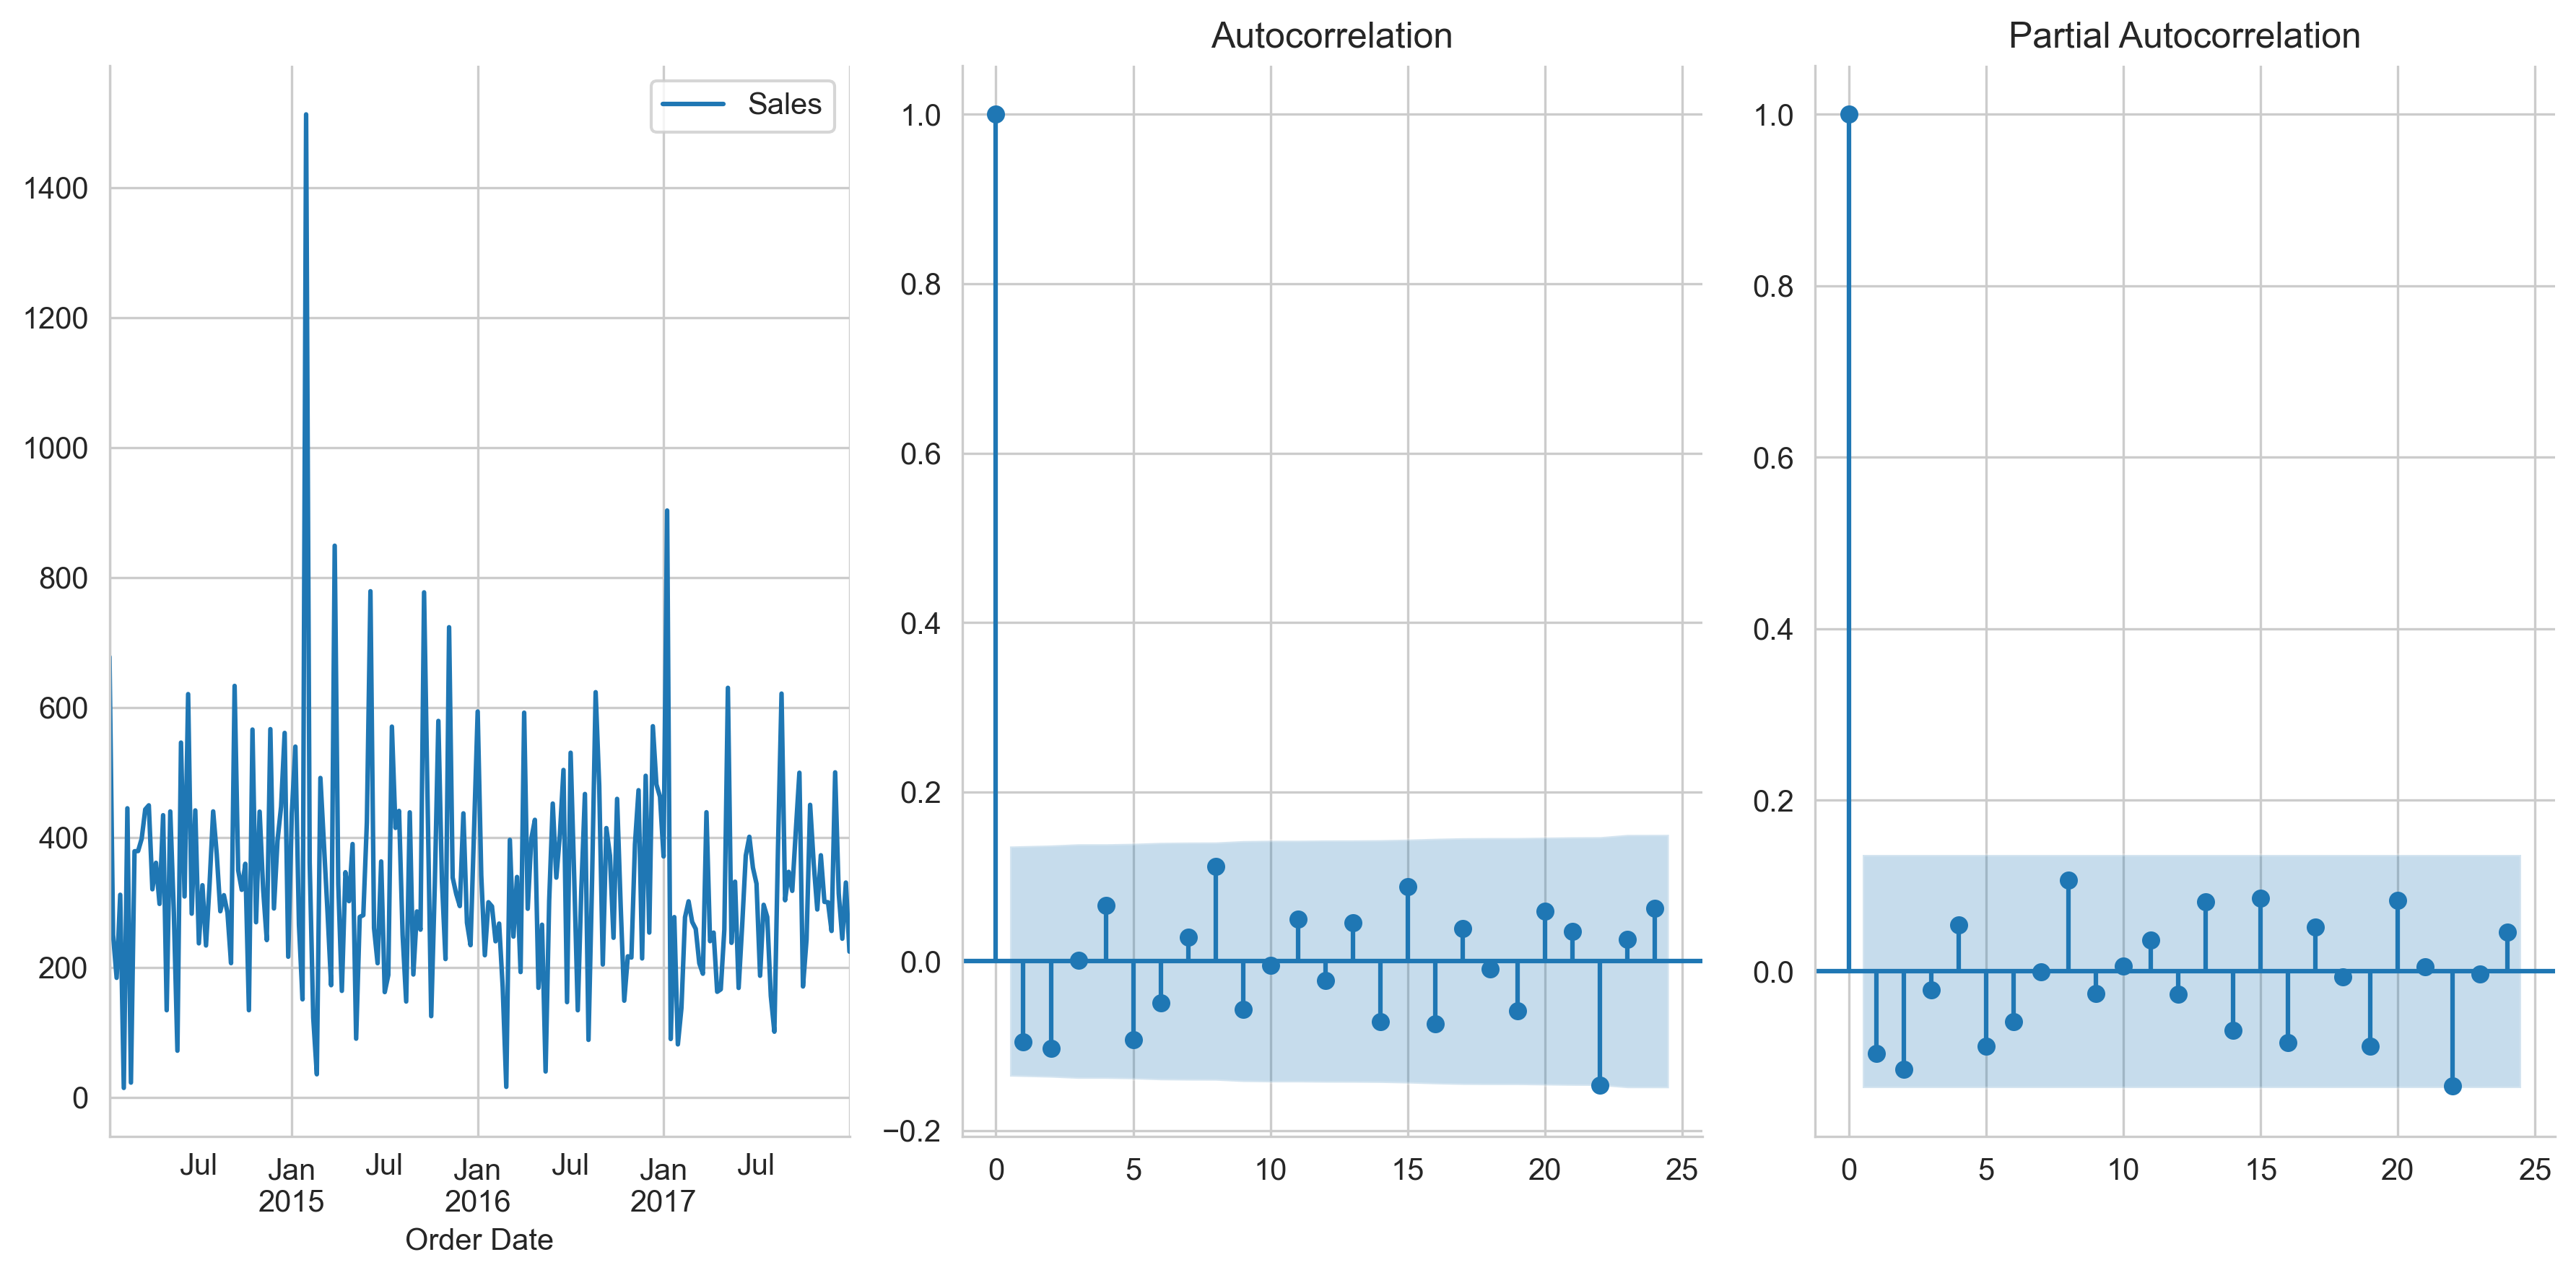

In [213]:
# helper plot for monthly temps
plots(df_, lags=24);
# open Duke guide for visual
# we note a 12-period cycle (yearly) with suspension bridge design, so must use SARIMA

In [214]:
# we might need to install dev version for statespace functionality
#!pip install git+https://github.com/statsmodels/statsmodels.git
import statsmodels.api as sm

# fit SARIMA monthly based on helper plots
sar = sm.tsa.statespace.SARIMAX(df_['Sales'], order=(1,1,0), seasonal_order=(0,1,0,12), trend='c').fit()
sar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                  208
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood               -1401.949
Date:                            Fri, 10 Dec 2021   AIC                           2809.897
Time:                                    17:27:45   BIC                           2819.716
Sample:                                01-12-2014   HQIC                          2813.873
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.7342     23.156      0.032      0.975     -44.651      46.120
ar.L1         -0.5281      0.049    -10.743      0.000      -0.624      -0.432
sigma2      1.026e+05   7098.728     14.448      0.000    8.87e+04    1.16e+05
===================================================================================
Ljung-Box (L1) (Q):                   7.63   Jarque-Bera (JB):                44.73
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.45   Skew:                            -0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

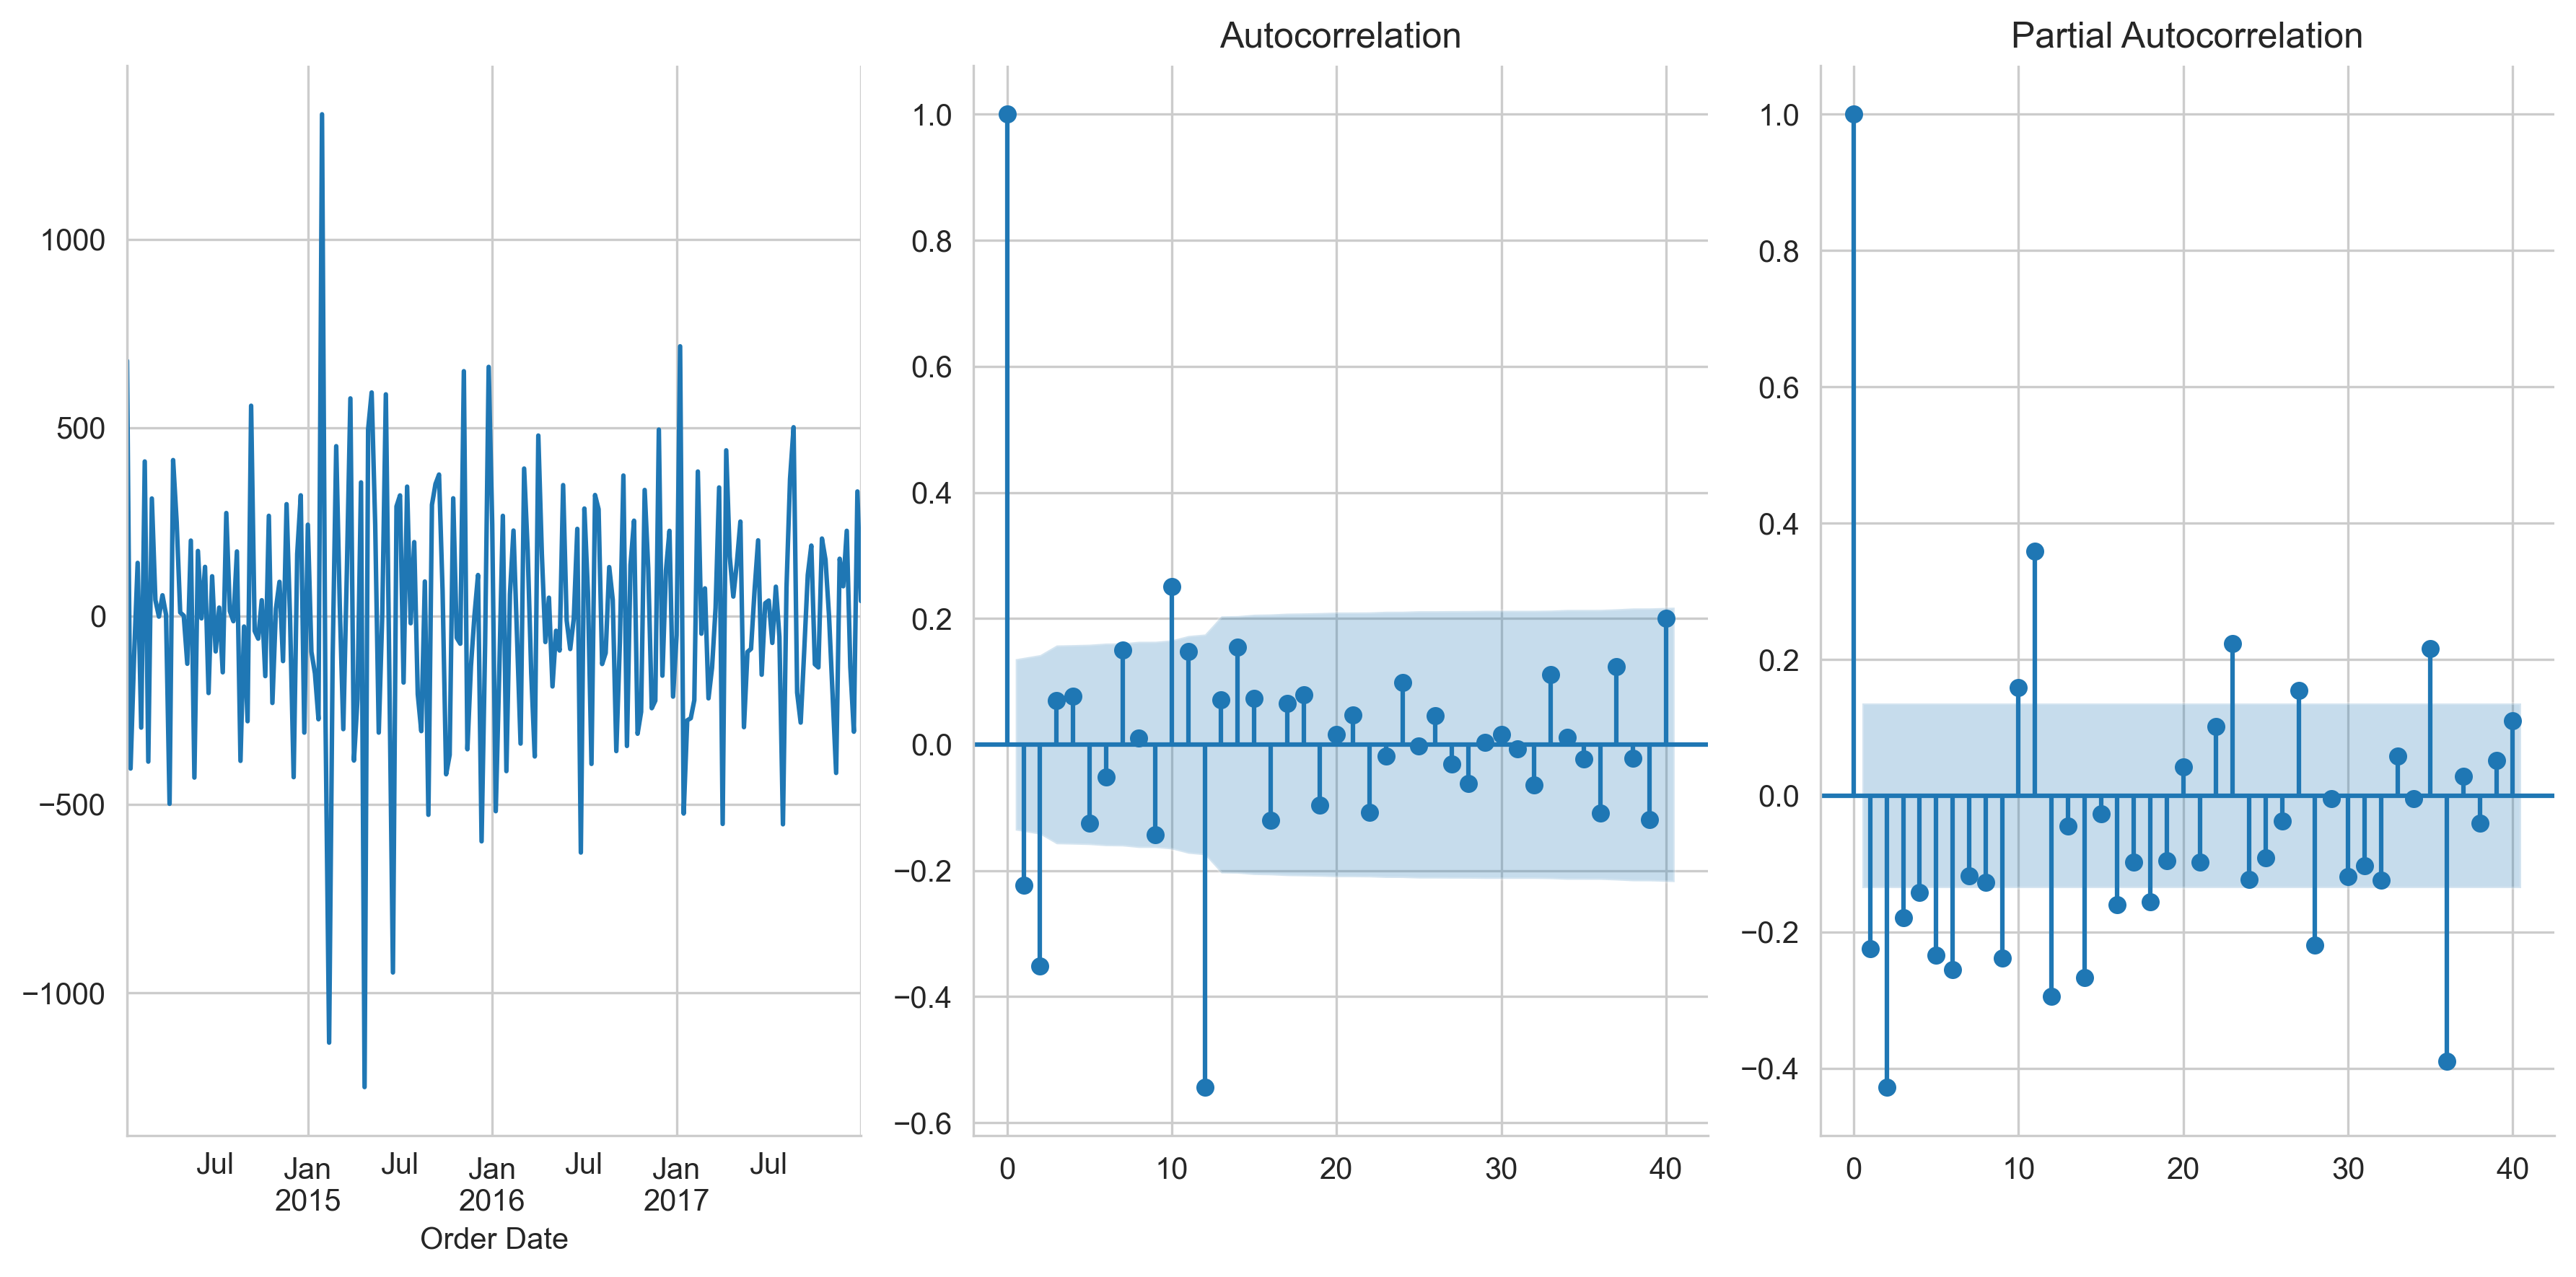

In [215]:
# plot resids
plots(sar.resid, lags=40);

# Thought process: (Reference: https://people.duke.edu/~rnau/arimrule.htm)
# 010010 is overdiff by AIC and negative ACR, but 000010 is a big underdiff with better AIC
# we pick 000010,12 and Trend='c' per rule4/5

# now look at seasonal, notice negative ACR spike at 12: per rule 13, we add a SMA term
# big drop to 4284 AIC
# looks like ACR looks good at seasonal lags, so we move back to ARIMA portion

# rule6 says we're a bit underdiff, so we add AR=3 based on PACF: 4261 AIC

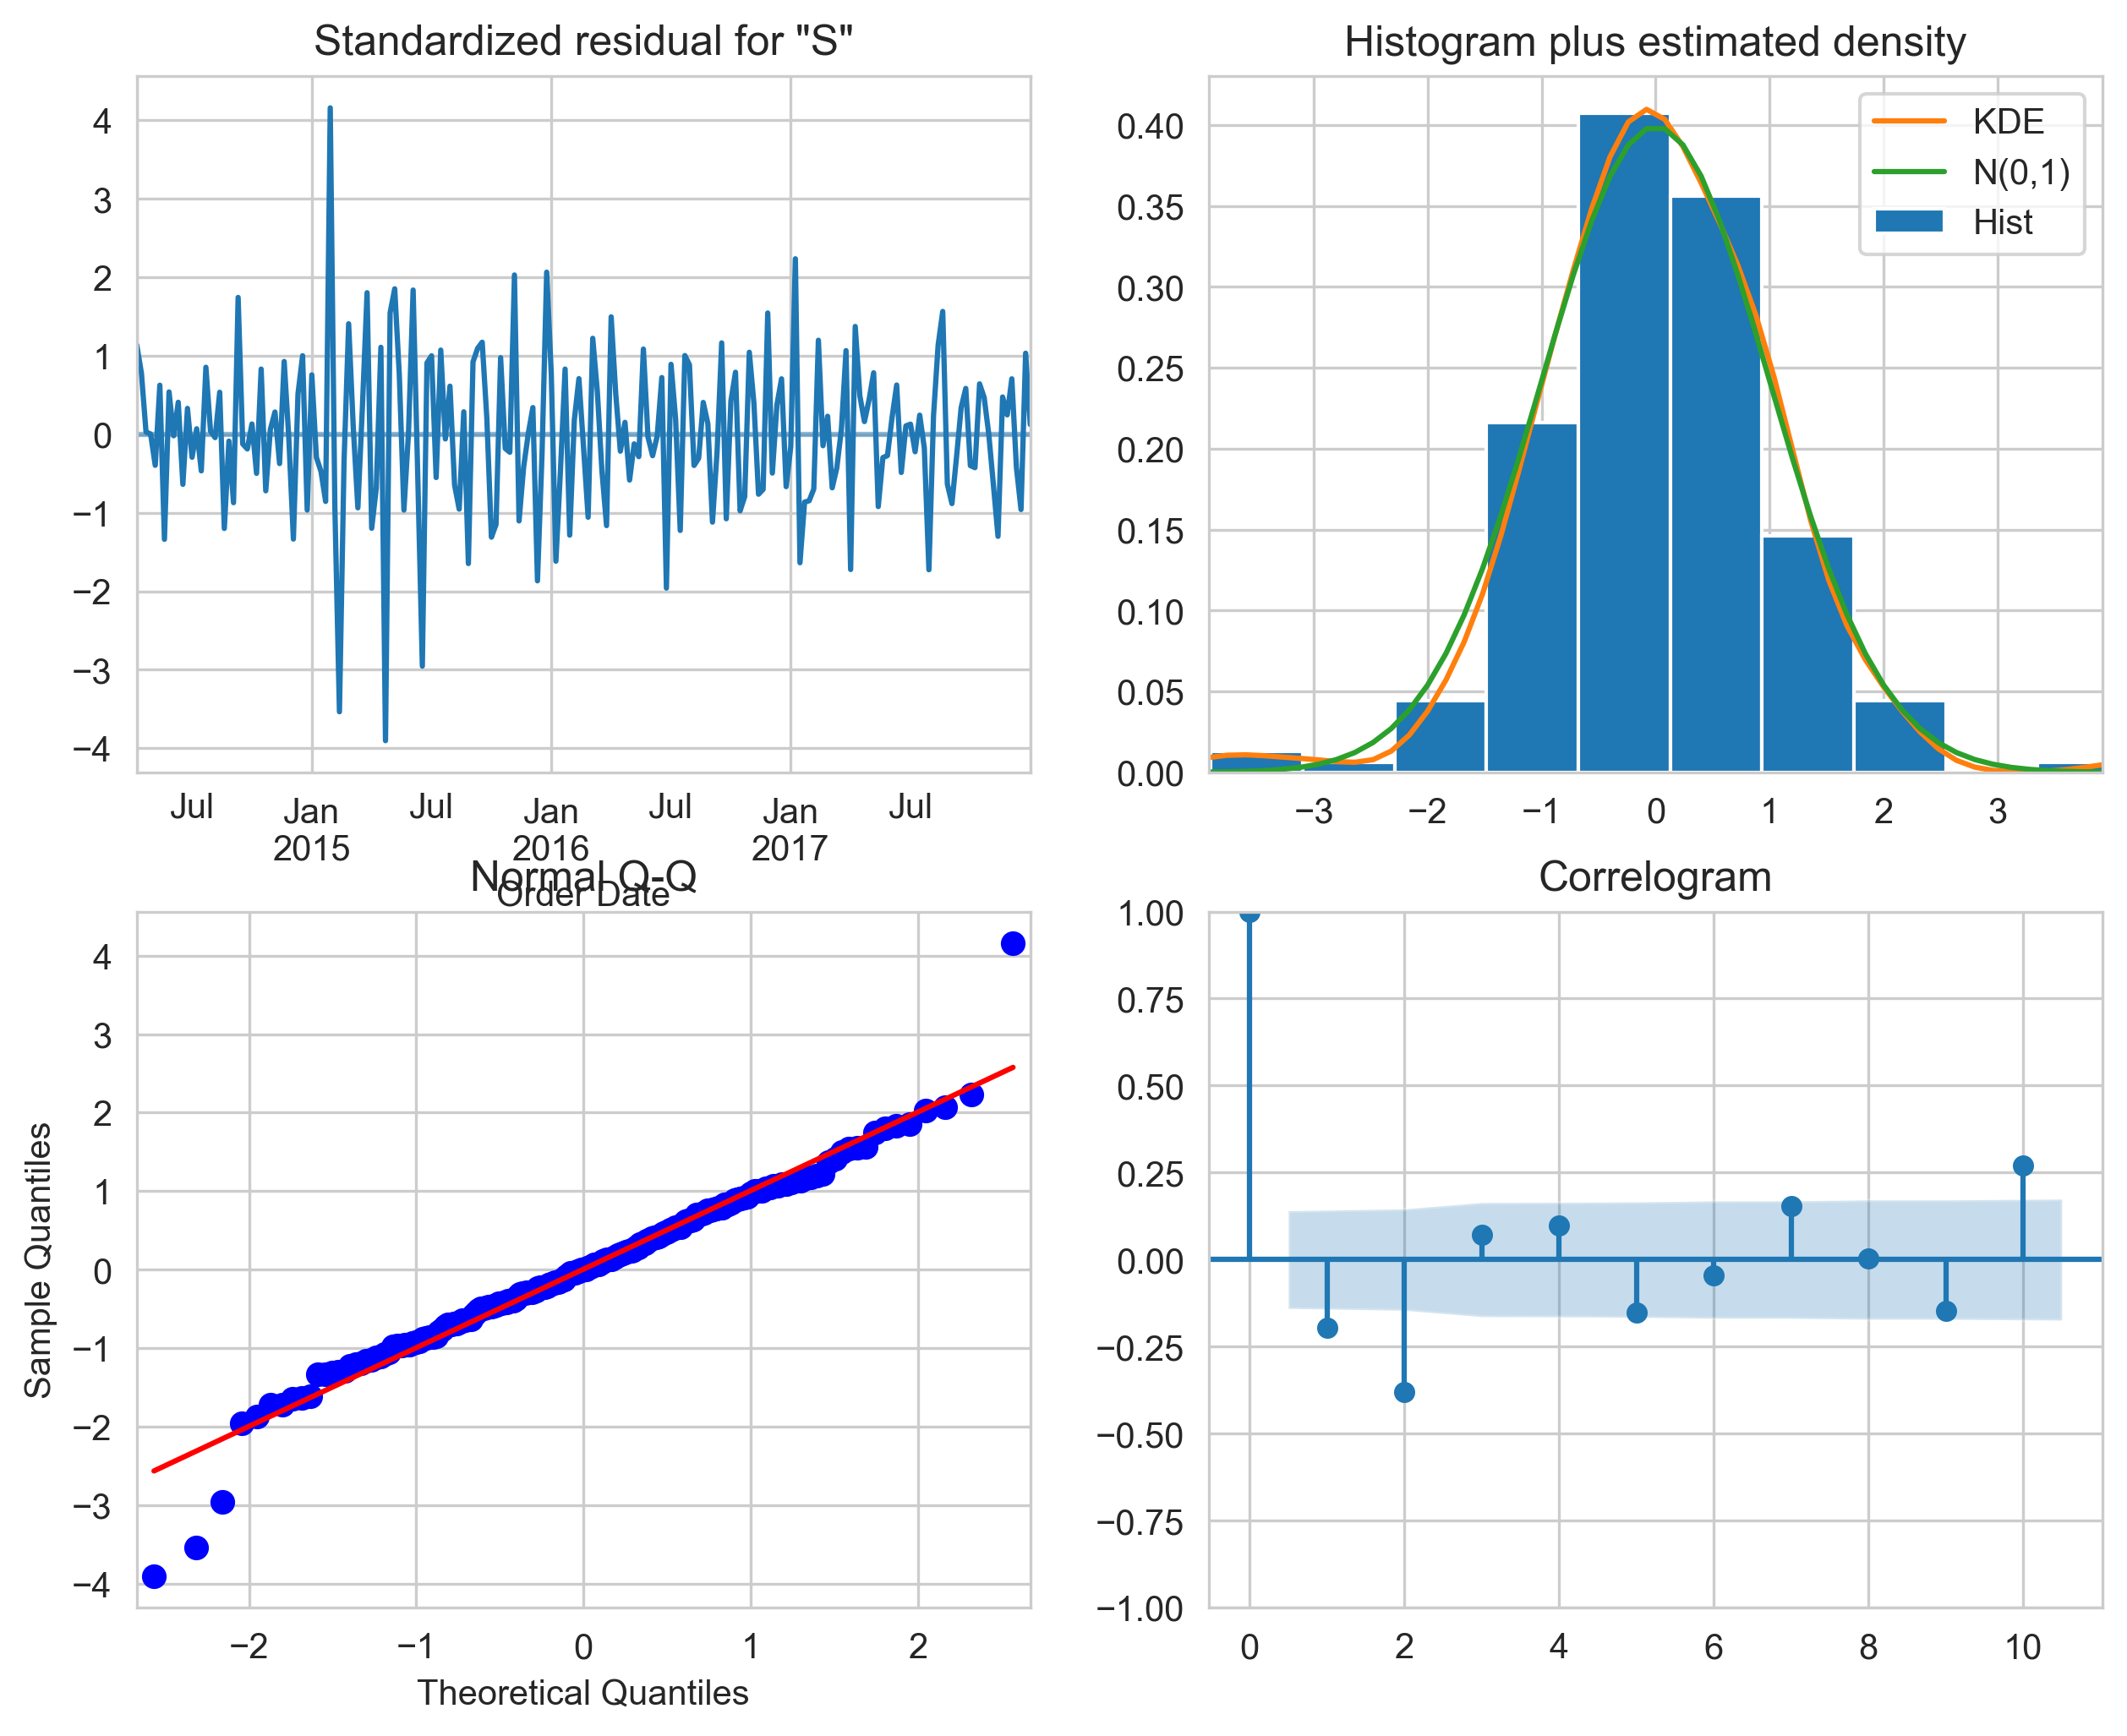

In [216]:
# plot residual diagnostics
sar.plot_diagnostics(figsize=(10, 8));

In [412]:
df_

Sales          L1          L2          L3          L4  \
Order Date                                                               
2014-03-02  378.799000   22.740000  444.904500   14.560000  311.833000   
2014-03-09  379.157200  378.799000   22.740000  444.904500   14.560000   
2014-03-16  397.978667  379.157200  378.799000   22.740000  444.904500   
2014-03-23  443.197333  397.978667  379.157200  378.799000   22.740000   
2014-03-30  449.483286  443.197333  397.978667  379.157200  378.799000   
...                ...         ...         ...         ...         ...   
2017-12-03  500.255375  256.107259  300.318125  300.884095  372.645217   
2017-12-10  314.085857  500.255375  256.107259  300.318125  300.884095   
2017-12-17  244.201000  314.085857  500.255375  256.107259  300.318125   
2017-12-24  330.638318  244.201000  314.085857  500.255375  256.107259   
2017-12-31  224.309156  330.638318  244.201000  314.085857  500.255375   

                    L5          L6          L7  
Order Date                                      
2014-03-02  183.995333  250.094600  678.107000  
2014-03-09  311.833000  183.995333  250.094600  
2014-03-16   14.560000  311.833000  183.995333  
2014-03-23  444.904500   14.560000  311.833000  
2014-03-30   22.740000  444.904500   14.560000  
...                ...         ...         ...  
2017-12-03  289.184800  359.849950  450.233000  
2017-12-10  372.645217  289.184800  359.849950  
2017-12-17  300.884095  372.645217  289.184800  
2017-12-24  300.318125  300.884095  372.645217  
2017-12-31  256.107259  300.318125  300.884095  

[201 rows x 8 columns]

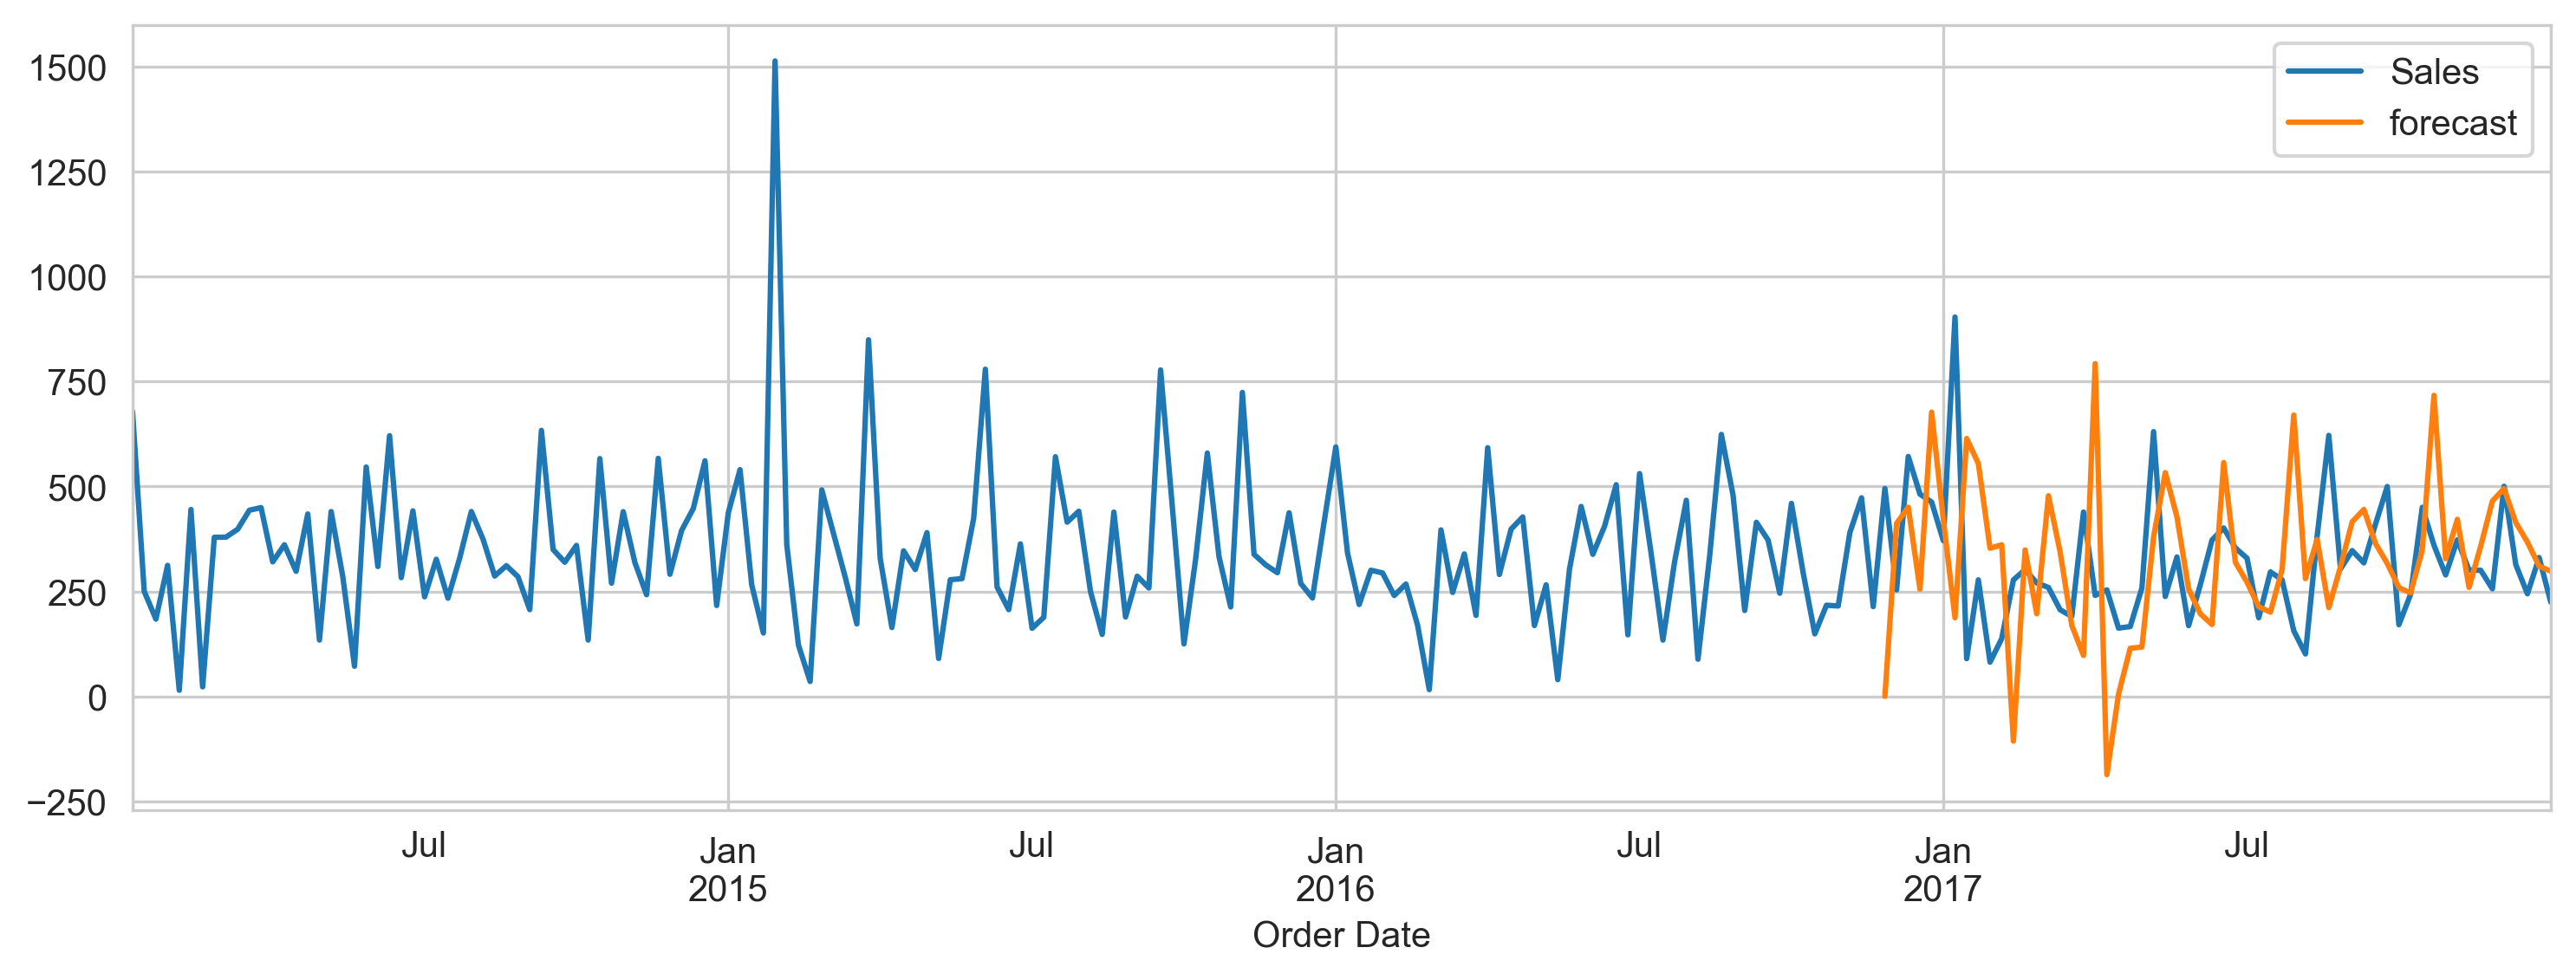

In [218]:
# plot predictions
df_['forecast'] = sar.predict(start=150, end=364, dynamic=30)  
df_[:][['Sales', 'forecast']].plot();

# per the documentation, we start predicting at period 750, and start a dynamic forecast at 750 + 30
# this means we use our predictions as "ground truth" for following predictions

#### Method #02 : Seasonal Adjustment

### Method #03 : Holt-Winters

In [415]:
from statsmodels.tsa.seasonal import seasonal_decompose

#### Seasonal decomposition (TLS)

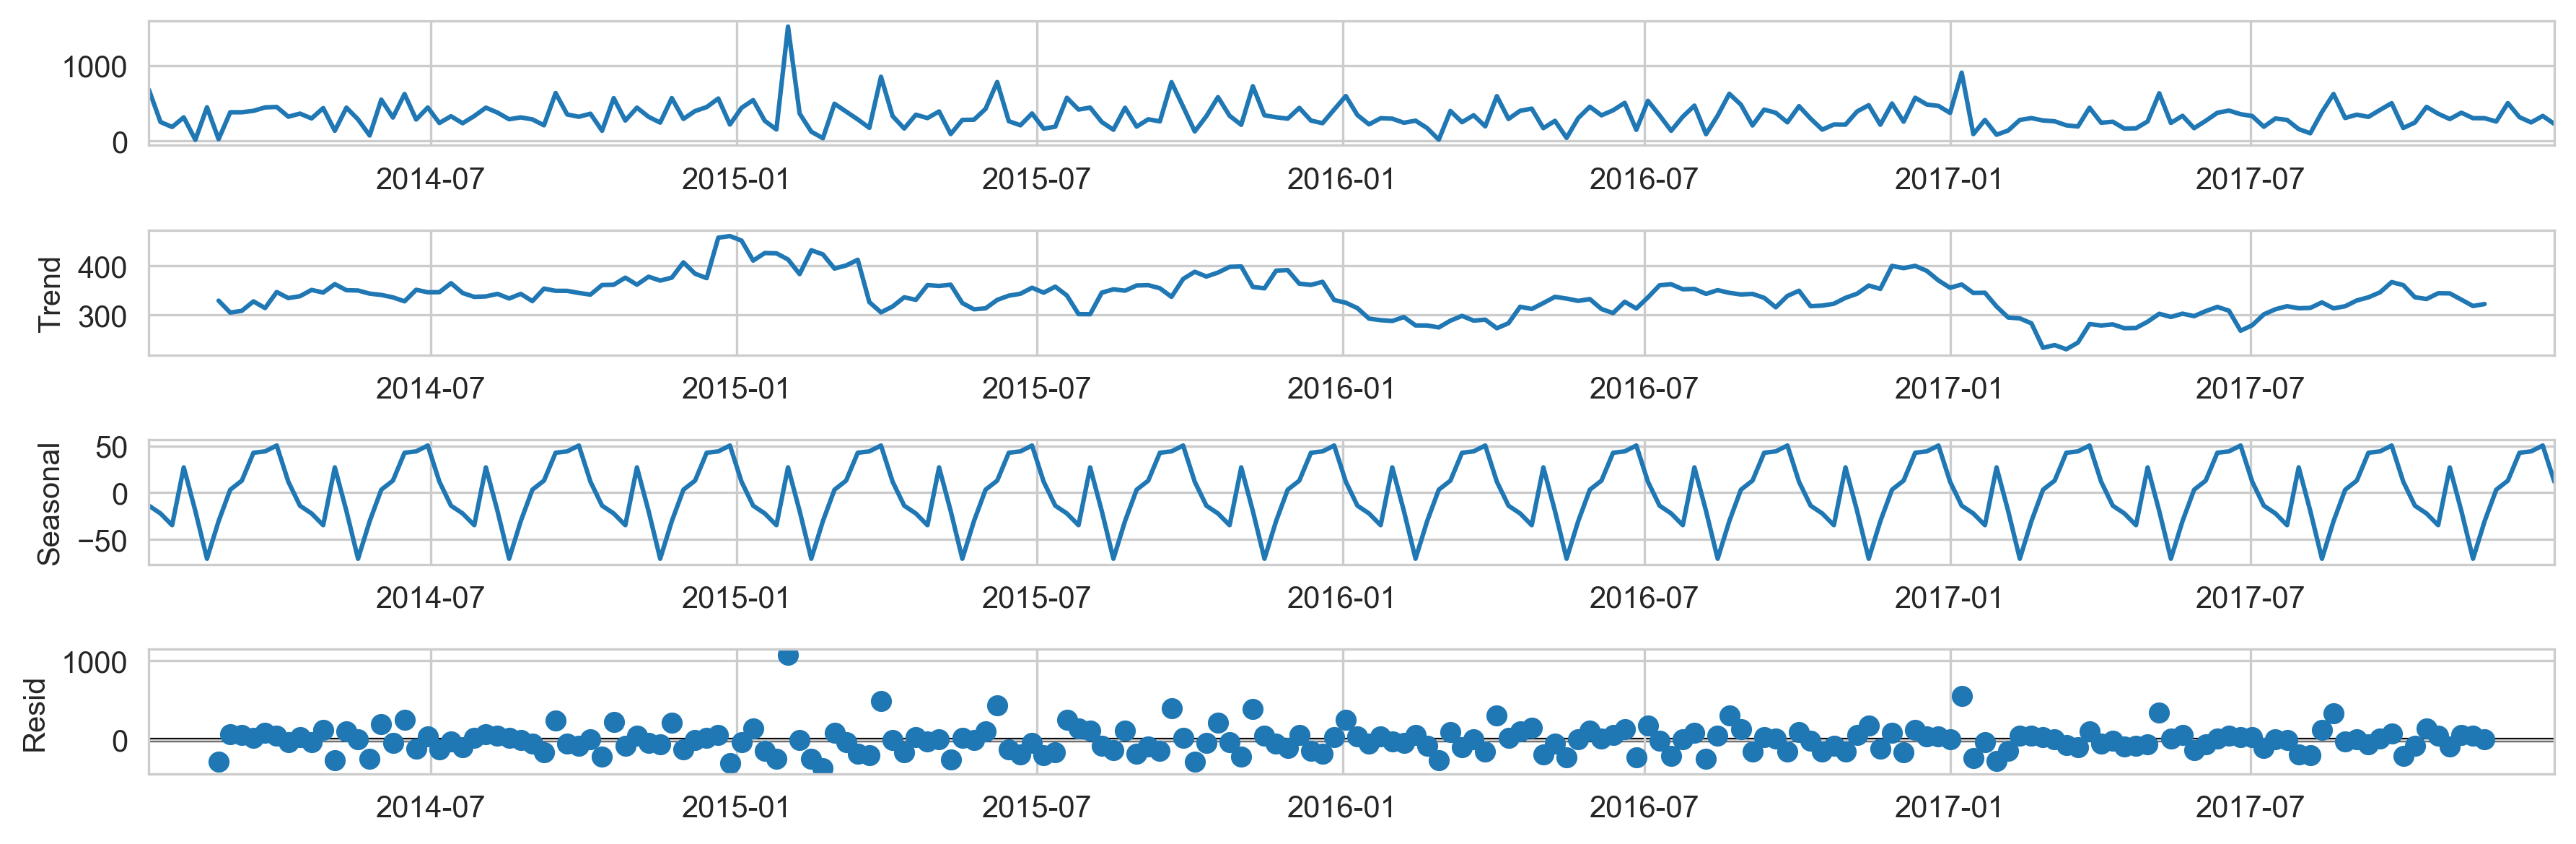

In [436]:
decomposition = seasonal_decompose(df_, model='additive', period=13)
decomposition.plot();

#### Stationarizing the data

                            OLS Regression Results                            
Dep. Variable:                  trend   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     35.57
Date:                Fri, 10 Dec 2021   Prob (F-statistic):           1.15e-08
Time:                        20:32:35   Log-Likelihood:                -983.09
No. Observations:                 196   AIC:                             1970.
Df Residuals:                     194   BIC:                             1977.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        365.0529      5.219     69.951      0.0

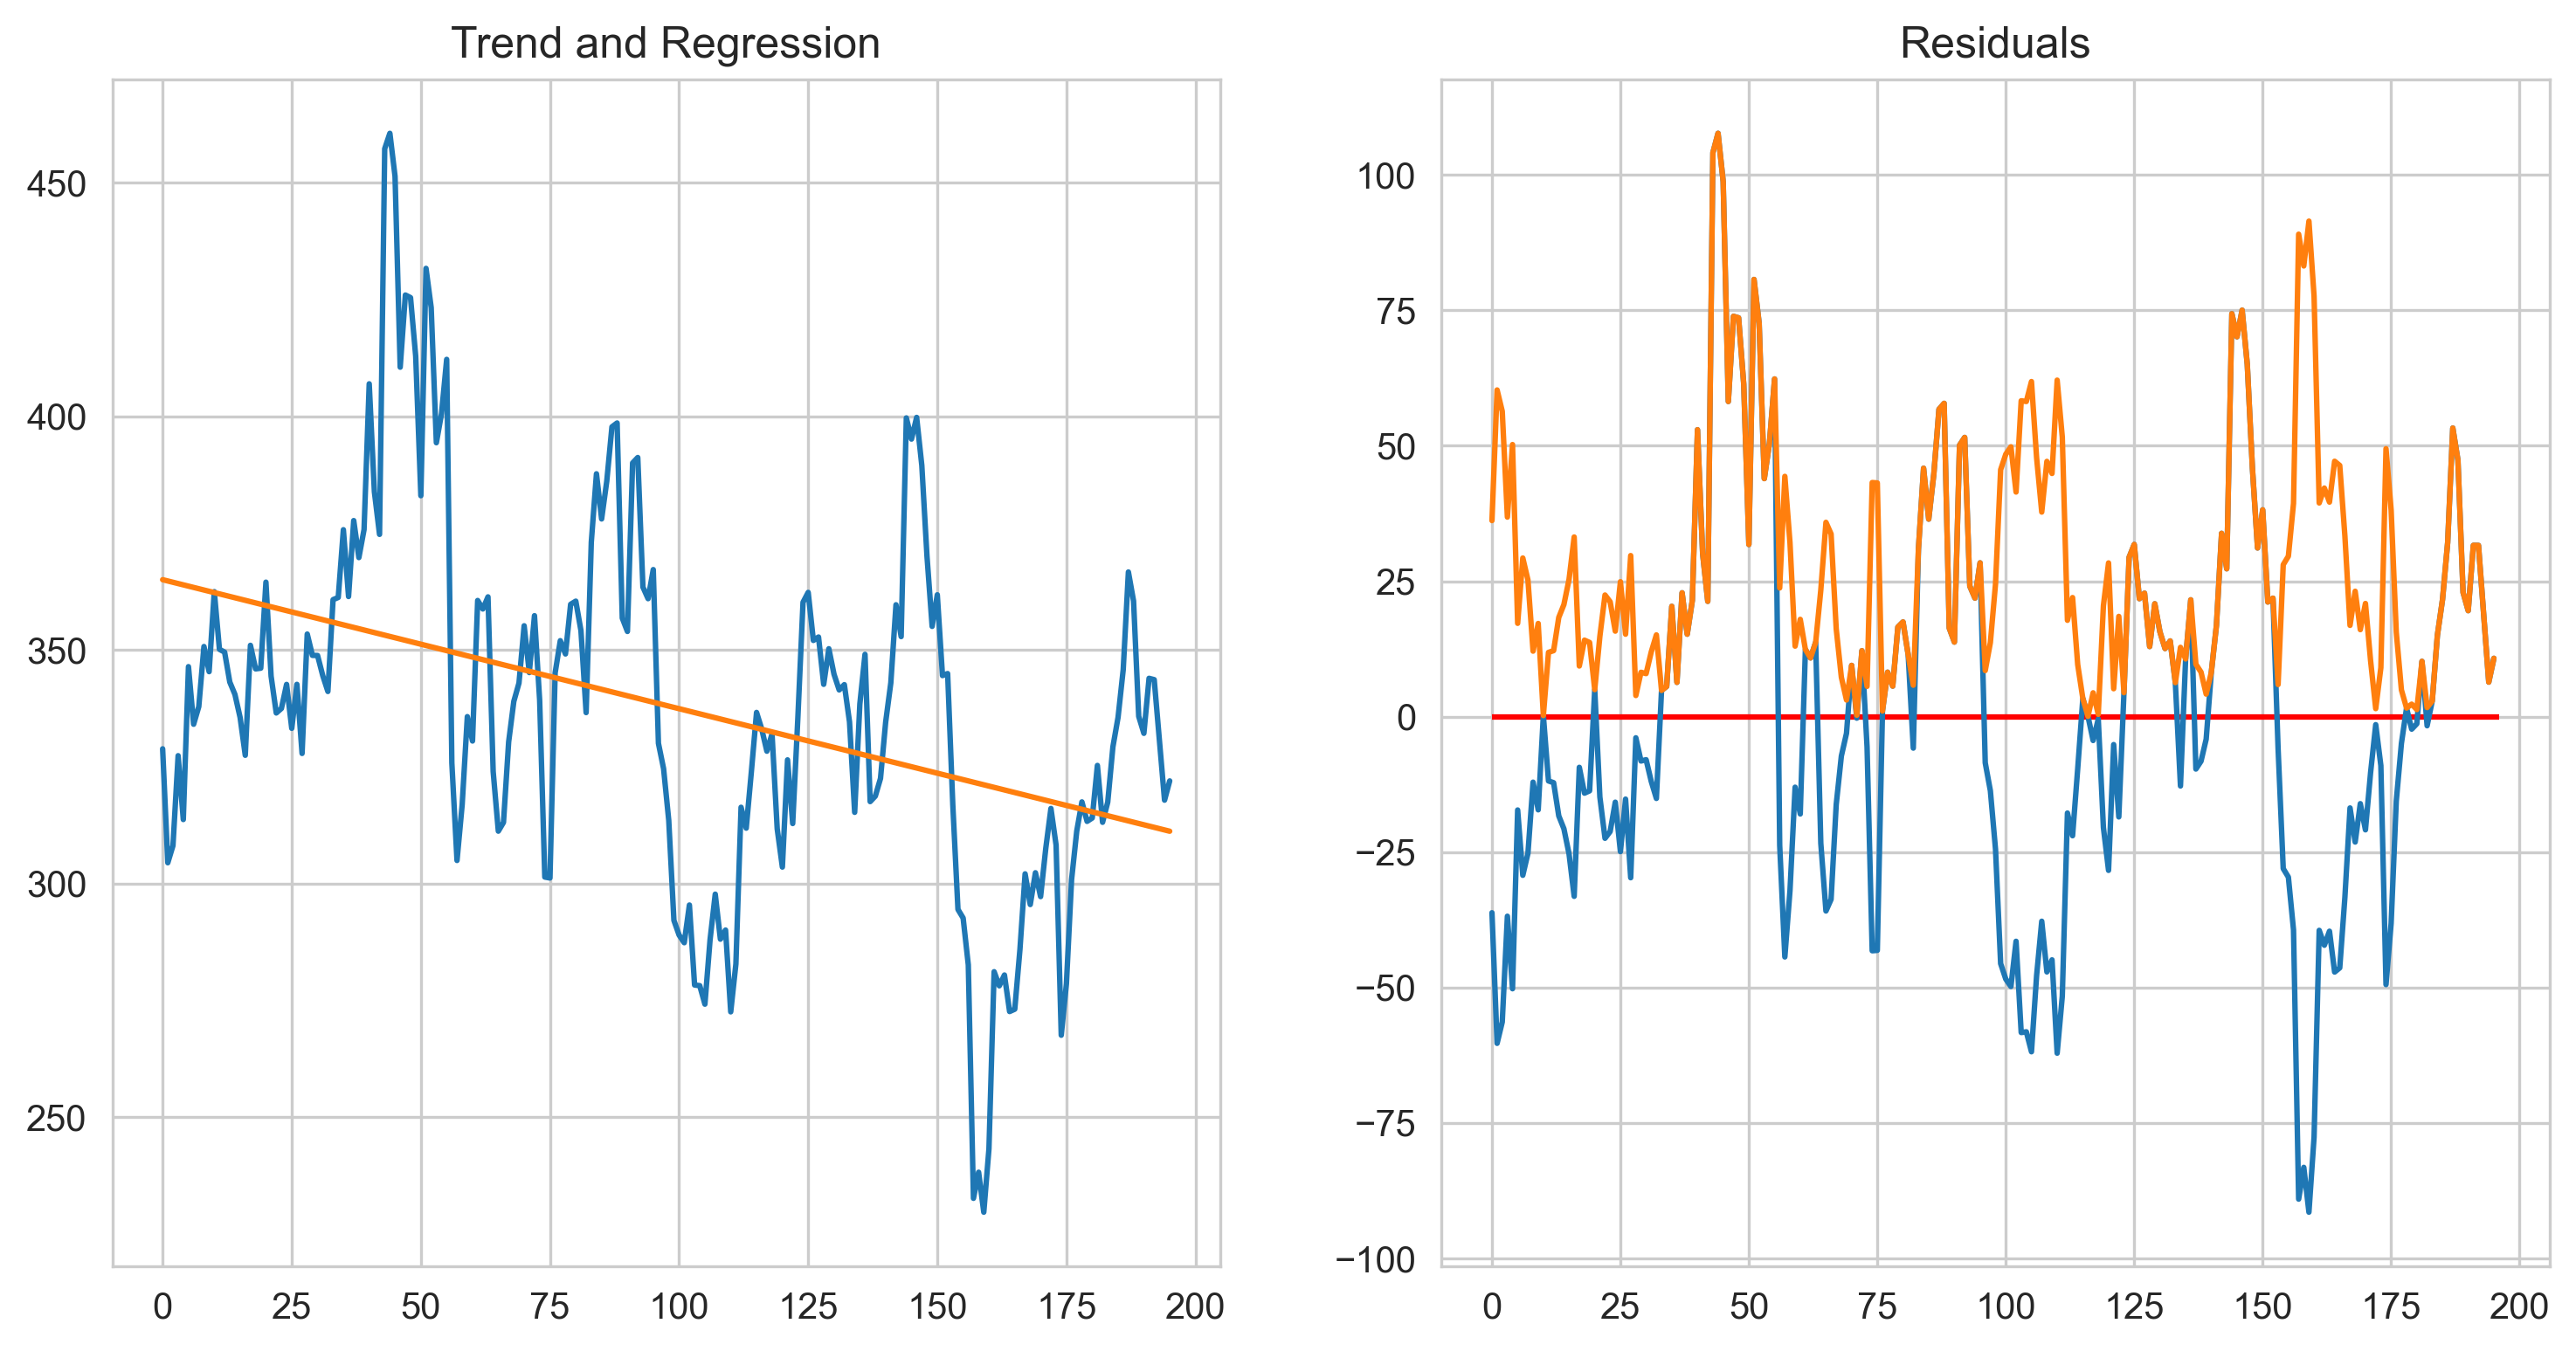

In [439]:

import statsmodels.api as sm
from statsmodels.api import OLS

x, y = np.arange(len(decomposition.trend.dropna())), decomposition.trend.dropna()
x = sm.add_constant(x)
model = OLS(y, x)
res = model.fit()
print(res.summary())

fig, ax = plt.subplots(1, 2, figsize=(12,6));
ax[0].plot(decomposition.trend.dropna().values, label='trend')
ax[0].plot([res.params.x1*i + res.params.const for i in np.arange(len(decomposition.trend.dropna()))])
ax[1].plot(res.resid.values);
ax[1].plot(np.abs(res.resid.values));
ax[1].hlines(0, 0, len(res.resid), color='r');
ax[0].set_title("Trend and Regression");
ax[1].set_title("Residuals");

In [452]:
len(df_test.index)

53

In [451]:
len(pred)

24

C:\Users\alsah\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
C:\Users\alsah\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
<ipython-input-453-fdab4eae205d>:4: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  model2 = ExponentialSmoothing(df_train, trend="add", seasonal="add", seasonal_periods=12, damped=True)
C:\Users\alsah\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'


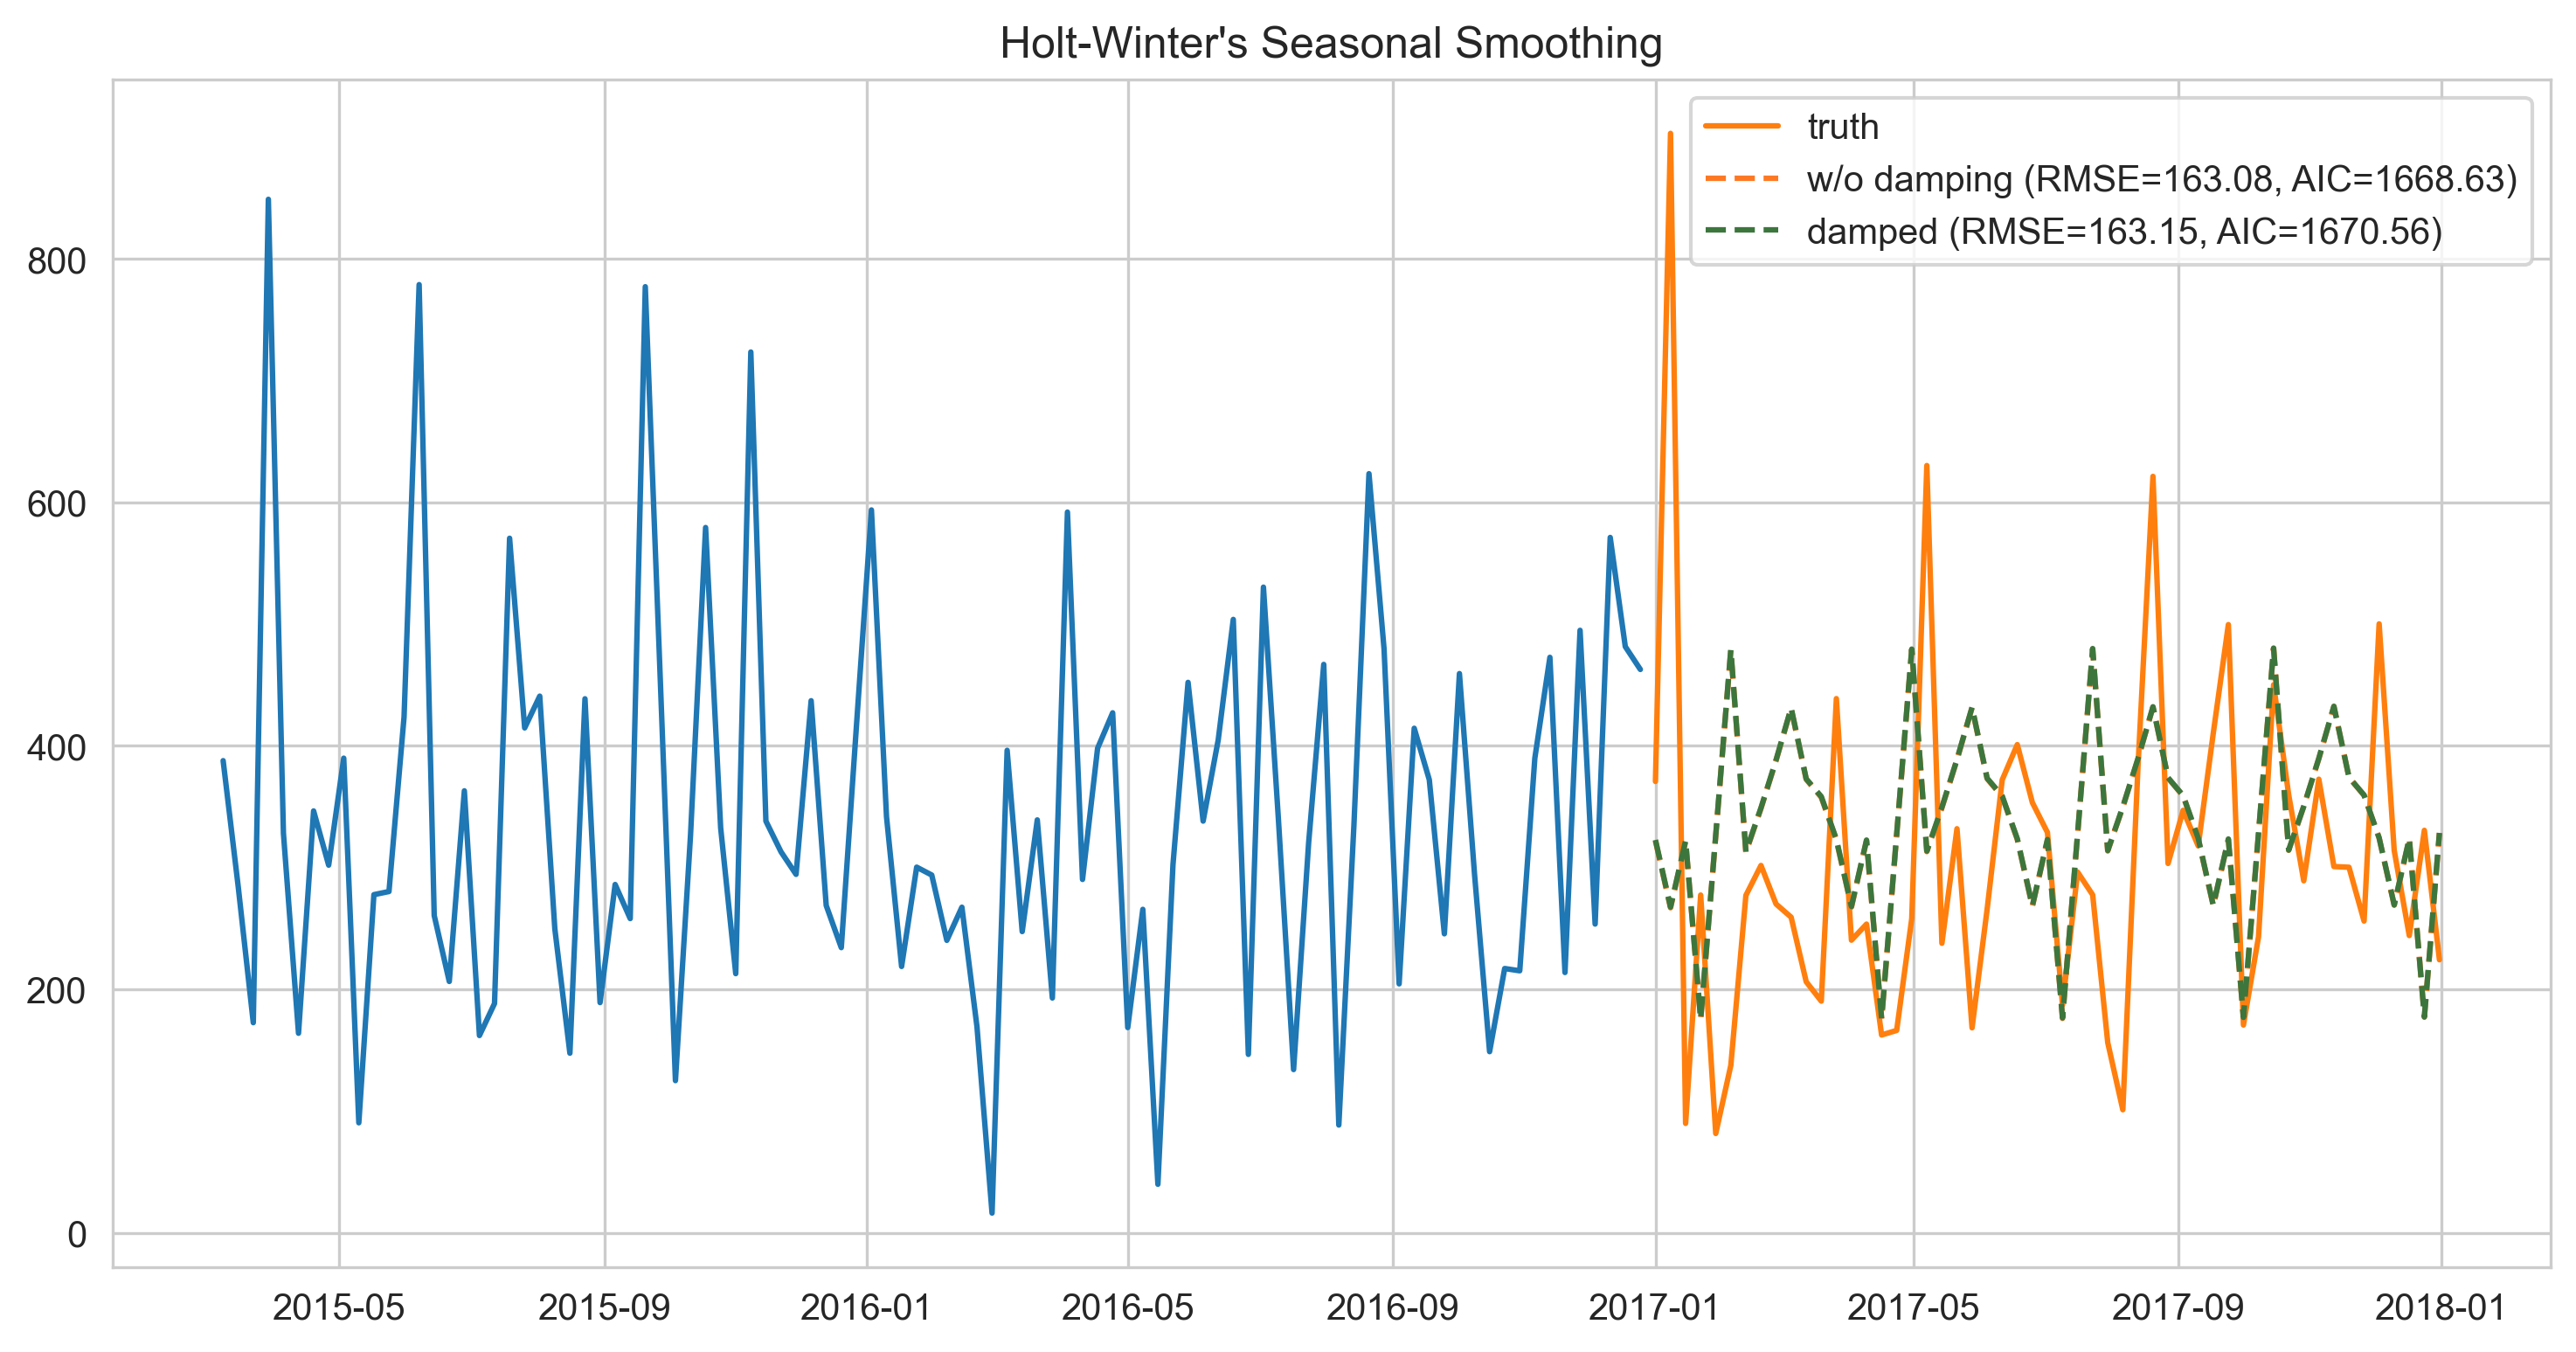

In [453]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(df_train, trend="add", seasonal="add", seasonal_periods=12)
model2 = ExponentialSmoothing(df_train, trend="add", seasonal="add", seasonal_periods=12, damped=True)
fit = model.fit()
pred = fit.forecast(len(df_test))
fit2 = model2.fit()
pred2 = fit2.forecast(len(df_test))

sse1 = np.sqrt(np.mean(np.square(df_test.values - pred.values)))
sse2 = np.sqrt(np.mean(np.square(df_test.values - pred2.values)))

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df_train.index[60:], df_train.values[60:]);
ax.plot(df_test.index, df_test.values, label='truth');
ax.plot(df_test.index, pred, linestyle='--', color='#ff7823', label="w/o damping (RMSE={:0.2f}, AIC={:0.2f})".format(sse1, fit.aic));
ax.plot(df_test.index, pred2, linestyle='--', color='#3c763d', label="damped (RMSE={:0.2f}, AIC={:0.2f})".format(sse2, fit2.aic)); 
ax.legend();
ax.set_title("Holt-Winter's Seasonal Smoothing");

#### SARIMA

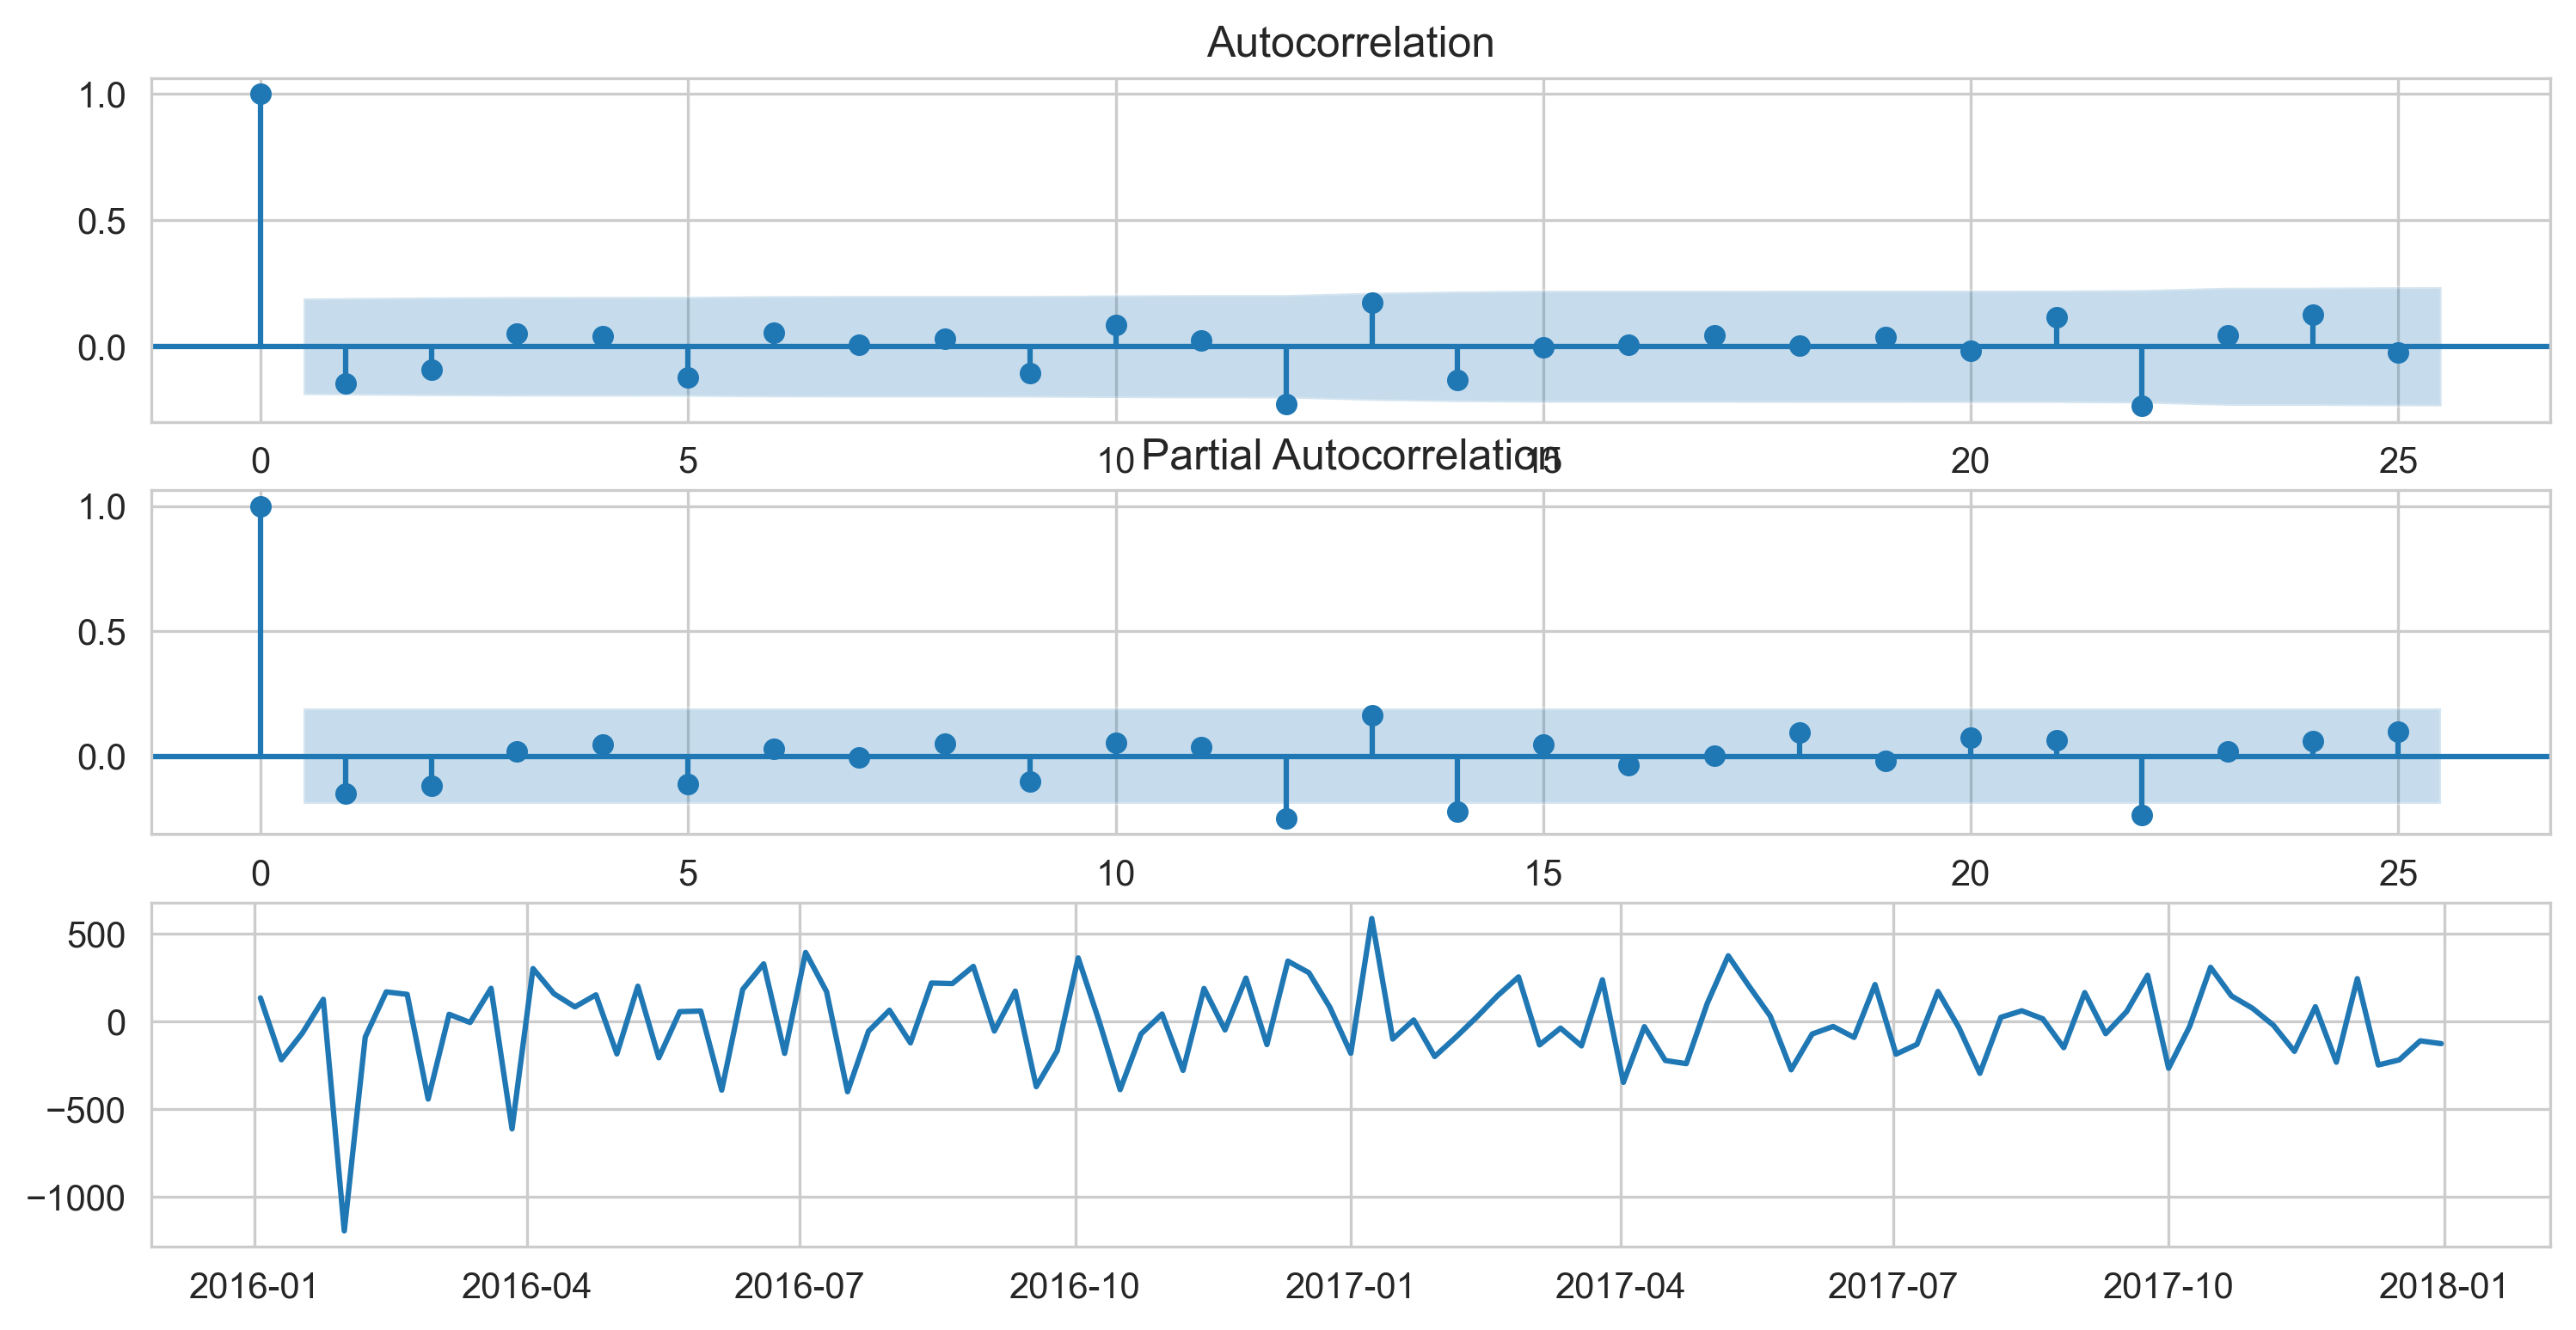

In [468]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Stationary data
df_['station'] = df_.Sales - df_.Sales.rolling(52).mean()

fig, ax = plt.subplots(3, figsize=(12,6))
x = (df_.station.dropna() - df_.station.dropna().shift(52)).dropna()
ax[0] = plot_acf(x, ax=ax[0], lags=25)
ax[1] = plot_pacf(x, ax=ax[1], lags=25)
ax[2].plot(x)

In [480]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

train_st = df_train
test_st = df_test
sarima_model = SARIMAX(train_st, order=(0, 1, 2), seasonal_order=(0, 1, 2, 52), enforce_invertibility=False, enforce_stationarity=False)
sarima_fit = sarima_model.fit()

sarima_pred = sarima_fit.get_prediction("2018-01", "2020-12")
predicted_means = p.predicted_mean + df.data.iloc[-36:-1].rolling(52).mean().dropna().values
predicted_intervals = p.conf_int(alpha=0.05)
lower_bounds = predicted_intervals['lower station'] + df.data.iloc[-36:-1].rolling(52).mean().dropna().values
upper_bounds = predicted_intervals['upper station'] + df.data.iloc[-36:-1].rolling(52).mean().dropna().values

sarima_rmse = np.sqrt(np.mean(np.square(test_st.values - p.predicted_mean.values)))

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(df.data.index[100:-24], df.data.values[100:-24]);
ax.plot(test_st.index, test_st.values + df.data.iloc[-36:-1].rolling(52).mean().dropna().values, label='truth');
ax.plot(test_st.index, predicted_means, color='#ff7823', linestyle='--', label="prediction (RMSE={:0.2f})".format(sarima_rmse));
ax.fill_between(test_st.index, lower_bounds, upper_bounds, color='#ff7823', alpha=0.3, label="confidence interval (95%)");
ax.legend();
ax.set_title("SARIMA");

C:\Users\alsah\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
C:\Users\alsah\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
C:\Users\alsah\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


AttributeError: 'DecomposeResult' object has no attribute 'predicted_mean'

## Model Development

## Evaluation

In [183]:
# # Accuracy metrics
# def forecast_accuracy(forecast, actual):
#     mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
#     me = np.mean(forecast - actual)             # ME
#     mae = np.mean(np.abs(forecast - actual))    # MAE
#     mpe = np.mean((forecast - actual)/actual)   # MPE
#     rmse = np.mean((forecast - actual)**2)**.5  # RMSE
#     corr = np.corrcoef(forecast, actual)[0,1]   # corr
#     mins = np.amin(np.hstack([forecast[:,None], 
#                               actual[:,None]]), axis=1)
#     maxs = np.amax(np.hstack([forecast[:,None], 
#                               actual[:,None]]), axis=1)
#     minmax = 1 - np.mean(mins/maxs)             # minmax
#     acf1 = acf(fc-test)[1]                      # ACF1
#     return({'mape':mape, 'me':me, 'mae': mae, 
#             'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
#             'corr':corr, 'minmax':minmax})

In [184]:
# forecast_accuracy(fc, test.values)

In [186]:
# # create and run statistical tests on model
# norm_val, norm_p, skew, kurtosis = sar.test_normality('jarquebera')[0]
# lb_val, lb_p = sar.test_serial_correlation(method='ljungbox')[0]
# het_val, het_p = sar.test_heteroskedasticity('breakvar')[0]
# # we want to look at largest lag for Ljung-Box, so take largest number in series
# # there's intelligence in the method to determine how many lags back to calculate this stat
# lb_val = lb_val[-1]
# lb_p = lb_p[-1]
# durbin_watson = sm.stats.stattools.durbin_watson(sar.filter_results.standardized_forecasts_error[0, sar.loglikelihood_burn:])

# print('Normality: val={:.3f}, p={:.3f}'.format(norm_val, norm_p));
# print('Ljung-Box: val={:.3f}, p={:.3f}'.format(lb_val, lb_p));
# print('Heteroskedasticity: val={:.3f}, p={:.3f}'.format(het_val, het_p));
# print('Durbin-Watson: d={:.2f}'.format(durbin_watson))